In [1]:
%pip install pycountry_convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.3/247.3 kB 13.4 MB/s eta 0:00:00


In [2]:
import math
from os.path import join
from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss, precision_recall_curve, auc

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb

import tensorflow as tf

from matplotlib import pyplot as plt

import pycountry_convert as pc
# import keras_tuner as kt
# from keras_tuner import HyperParameters

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Data and Basic EDA

In [4]:
# Read data and print shape + head
path = '/content/drive/MyDrive/Colab Notebooks/data/'
hotel_bks_init = pd.read_csv(path + 'hotel_bookings.csv')

print('Shape of data:', hotel_bks_init.shape)
hotel_bks_init.head()

Shape of data: (119390, 32)


hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

In [5]:
hotel_bks_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [6]:
# Copy data frame
df = hotel_bks_init.copy()

In [7]:
# Validate is_canceled with reservation_status - canceled and no-show are considered canceled
df.groupby(['is_canceled', 'reservation_status']).size()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
dtype: int64

In [8]:
# Check distribution channels by market segment
df.groupby(['market_segment','distribution_channel']).size()

market_segment  distribution_channel
Aviation        Corporate                 227
                TA/TO                      10
Complementary   Corporate                  89
                Direct                    576
                TA/TO                      78
Corporate       Corporate                4788
                Direct                    172
                TA/TO                     335
Direct          Corporate                  90
                Direct                  12276
                GDS                         1
                TA/TO                     237
                Undefined                   2
Groups          Corporate                1228
                Direct                   1472
                TA/TO                   17111
Offline TA/TO   Corporate                 212
                Direct                     16
                GDS                        45
                TA/TO                   23946
Online TA       Corporate                  43
                Direct                    133
                GDS                       147
                TA/TO                   56153
                Undefined                   1
Undefined       Undefined                   2
dtype: int64

In [9]:
# Reserved and assigned room types
pd.concat([df.groupby('reserved_room_type').size(),df.groupby('assigned_room_type').size()], axis=1)

0      1
A  85994.0  74053
B   1118.0   2163
C    932.0   2375
D  19201.0  25322
E   6535.0   7806
F   2897.0   3751
G   2094.0   2553
H    601.0    712
L      6.0      1
P     12.0     12
I      NaN    363
K      NaN    279

In [10]:
df[(df.adr >= 0) & (df.adr < 5000)]

hotel  is_canceled  lead_time  arrival_date_year  \
0       Resort Hotel            0        342               2015   
1       Resort Hotel            0        737               2015   
2       Resort Hotel            0          7               2015   
3       Resort Hotel            0         13               2015   
4       Resort Hotel            0         14               2015   
...              ...          ...        ...                ...   
119385    City Hotel            0         23               2017   
119386    City Hotel            0        102               2017   
119387    City Hotel            0         34               2017   
119388    City Hotel            0        109               2017   
119389    City Hotel            0        205               2017   

       arrival_date_month  arrival_date_week_number  \
0                    July                        27   
1                    July                        27   
2                    July                        27   
3                    July                        27   
4                    July                        27   
...                   ...                       ...   
119385             August                        35   
119386             August                        35   
119387             August                        35   
119388             August                        35   
119389             August                        35   

        arrival_date_day_of_month  stays_in_weekend_nights  \
0                               1                        0   
1                               1                        0   
2                               1                        0   
3                               1                        0   
4                               1                        0   
...                           ...                      ...   
119385                         30                        2   
119386                         31                        2   
119387                         31                        2   
119388                         31                        2   
119389                         29                        2   

        stays_in_week_nights  adults  ...  deposit_type  agent company  \
0                          0       2  ...    No Deposit    NaN     NaN   
1                          0       2  ...    No Deposit    NaN     NaN   
2                          1       1  ...    No Deposit    NaN     NaN   
3                          1       1  ...    No Deposit  304.0     NaN   
4                          2       2  ...    No Deposit  240.0     NaN   
...                      ...     ...  ...           ...    ...     ...   
119385                     5       2  ...    No Deposit  394.0     NaN   
119386                     5       3  ...    No Deposit    9.0     NaN   
119387                     5       2  ...    No Deposit    9.0     NaN   
119388                     5       2  ...    No Deposit   89.0     NaN   
119389                     7       2  ...    No Deposit    9.0     NaN   

       days_in_waiting_list customer_type     adr  \
0                         0     Transient    0.00   
1                         0     Transient    0.00   
2                         0     Transient   75.00   
3                         0     Transient   75.00   
4                         0     Transient   98.00   
...                     ...           ...     ...   
119385                    0     Transient   96.14   
119386                    0     Transient  225.43   
119387                    0     Transient  157.71   
119388                    0     Transient  104.40   
119389                    0     Transient  151.20   

        required_car_parking_spaces  total_of_special_requests  \
0                                 0                          0   
1                                 0                          0   
2                                 0                          0   
3             

In [11]:
df[(df.babies > 5) | (df.babies > 5)]

hotel  is_canceled  lead_time  arrival_date_year  \
46619  City Hotel            0         37               2016   
78656  City Hotel            0         11               2015   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
46619            January                         3                         12   
78656            October                        42                         11   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
46619                        0                     2       2  ...   
78656                        2                     1       1  ...   

       deposit_type  agent company days_in_waiting_list    customer_type  \
46619    No Deposit    9.0     NaN                    0        Transient   
78656    No Deposit   95.0     NaN                    0  Transient-Party   

         adr  required_car_parking_spaces  total_of_special_requests  \
46619  84.45                            0                          1   
78656  95.00                            0                          0   

       reservation_status reservation_status_date  
46619           Check-Out              2016-01-14  
78656           Check-Out              2015-10-14  

[2 rows x 32 columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# Data Cleansing and Processing

In [13]:
# Data processing
df['agent'] = df['agent'].notna().astype(int)
df['arrival_date_month'] = pd.to_datetime(
    df['arrival_date_month'], format='%B').dt.month
df['children'] = df['children'].fillna(0)
df['company'] = df['company'].notna().astype(int)

# TODO (Chad): Map countries to continents
manual_map = {
    'CN': 'Asia',
    'TMP': 'Asia',       # Timor-Leste
    'UMI': 'Oceania',    # U.S. Minor Outlying Islands
    'ATA': 'Antarctica', # Antarctica
    'ATF': 'Antarctica', # French Southern Territories
    None: 'Unknown',
    float('nan'): 'Unknown'
}

def country_to_continent(country_code):
    try:
        if pd.isna(country_code) or country_code in manual_map:
            return manual_map.get(country_code, 'Unspecified')
        # conversion between iso
        country_alpha2 = pc.country_alpha3_to_country_alpha2(country_code)
        # iso convert to continent
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        return 'Unspecified'

df['continent'] = df['country'].apply(country_to_continent)

# Determine if customer got their desired room type
mask_equal = df['assigned_room_type'] == df['reserved_room_type']
mask_not_ik = ~df['assigned_room_type'].isin(['I', 'K'])
df['is_reserved_room_type'] = (mask_equal & mask_not_ik).astype(int)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  int32  
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [15]:
df.groupby(['country', 'continent']).size()

country  continent    
ABW      North America      2
AGO      Africa           362
AIA      North America      1
ALB      Europe            12
AND      Europe             7
                         ... 
VGB      North America      1
VNM      Asia               8
ZAF      Africa            80
ZMB      Africa             2
ZWE      Africa             4
Length: 177, dtype: int64

In [16]:
df[(df.adr < 0) | (df.adr > 5000)]

hotel  is_canceled  lead_time  arrival_date_year  \
14969  Resort Hotel            0        195               2017   
48515    City Hotel            1         35               2016   

       arrival_date_month  arrival_date_week_number  \
14969                   3                        10   
48515                   3                        13   

       arrival_date_day_of_month  stays_in_weekend_nights  \
14969                          5                        4   
48515                         25                        0   

       stays_in_week_nights  adults  ...  company  days_in_waiting_list  \
14969                     6       2  ...        0                     0   
48515                     1       2  ...        0                     0   

         customer_type      adr required_car_parking_spaces  \
14969  Transient-Party    -6.38                           0   
48515        Transient  5400.00                           0   

      total_of_special_requests  reservation_status  reservation_status_date  \
14969                         0           Check-Out               2017-03-15   
48515                         0            Canceled               2016-02-19   

       continent is_reserved_room_type  
14969     Europe                     0  
48515     Europe                     1  

[2 rows x 34 columns]

In [17]:
# Drop outliers for ADR (greater than 5000 and negative values)
df = df[(df.adr >= 0) & (df.adr < 5000)]

In [18]:
# Drop unneeded columns
df = df.drop(['country',
              'assigned_room_type',
              'arrival_date_day_of_month',
              'arrival_date_week_number',
              'arrival_date_year',
              'reservation_status',
              'reservation_status_date',
              'reserved_room_type'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119388 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119388 non-null  object 
 1   is_canceled                     119388 non-null  int64  
 2   lead_time                       119388 non-null  int64  
 3   arrival_date_month              119388 non-null  int32  
 4   stays_in_weekend_nights         119388 non-null  int64  
 5   stays_in_week_nights            119388 non-null  int64  
 6   adults                          119388 non-null  int64  
 7   children                        119388 non-null  float64
 8   babies                          119388 non-null  int64  
 9   meal                            119388 non-null  object 
 10  market_segment                  119388 non-null  object 
 11  distribution_channel            119388 non-null  object 
 12  is_repeated_guest    

# EDA Visualization

### Cancellations by Month

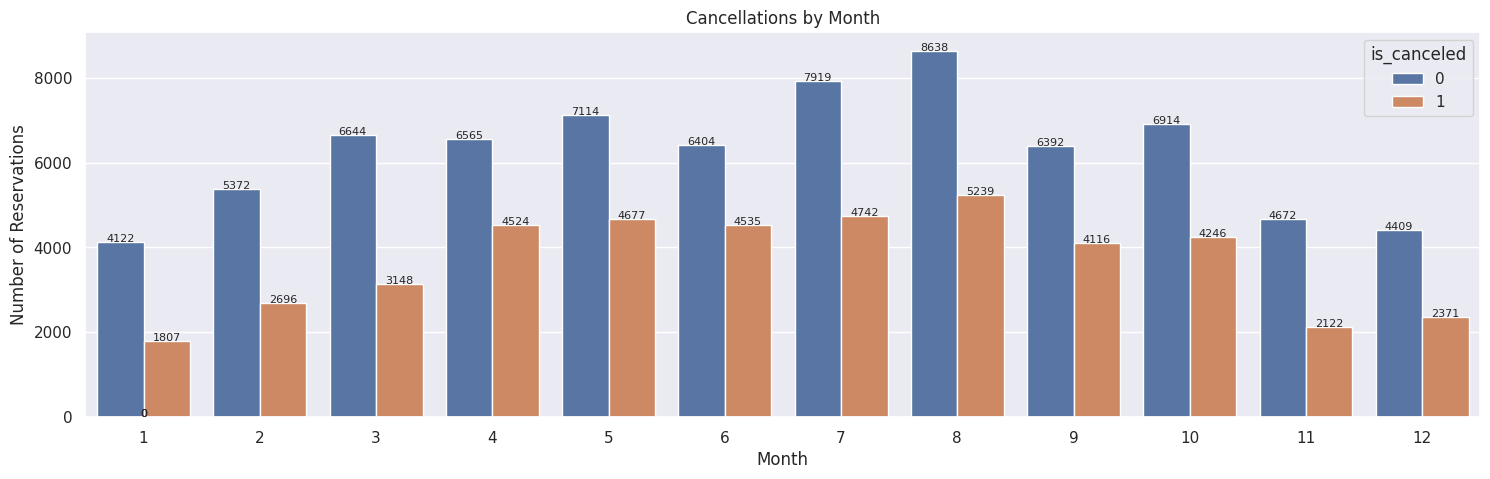

In [19]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x='arrival_date_month',
                   data=df,
                   hue='is_canceled')

# Add labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2,
            height + 0.5,
            f'{int(height)}',
            ha='center',
            fontsize=8)

# Add title/axes
plt.title('Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reservations')
plt.show()

### Cancellation % By Month

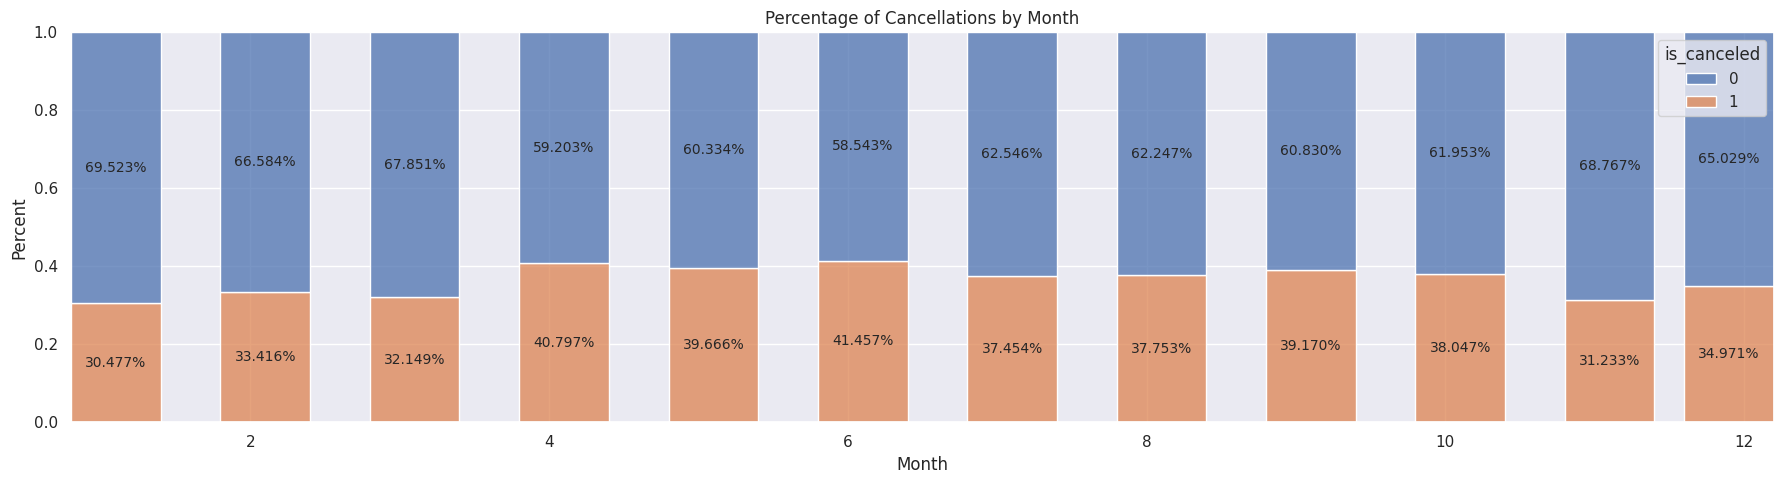

In [20]:
plt.figure(figsize=(18, 5))
ax = sns.histplot(
    x='arrival_date_month',
    data=df,
    hue='is_canceled',
    multiple='fill',
    shrink=3
)

# Add labels
for container in ax.containers:
    labels = [f'{h * 100:.3f}%' for h in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=10)

# Add title/axes
plt.title('Percentage of Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Percent')
plt.tight_layout()
plt.show()

### Cancellations vs Average Daily Rate (ADR)

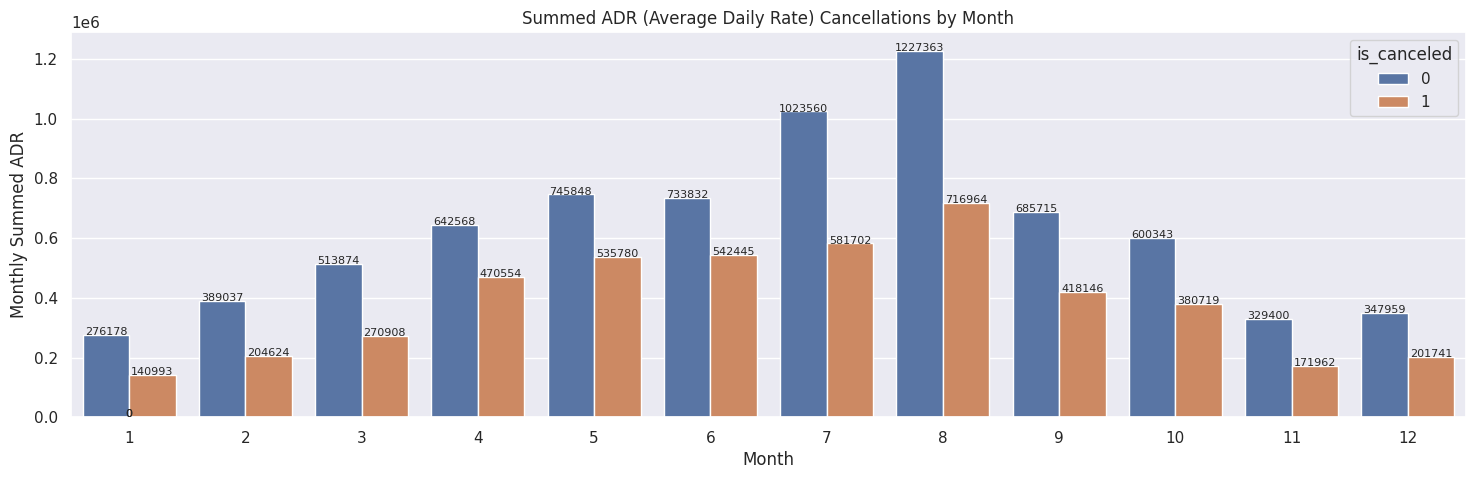

In [21]:
plt.figure(figsize=(18, 5))
ax = sns.barplot(x='arrival_date_month',
                 y='adr',
                 data=df.groupby(['arrival_date_month','is_canceled'])[['adr']].sum().reset_index(),
                 hue='is_canceled')

# Add labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2,
            height + 0.5,
            f'{int(height)}',
            ha='center',
            fontsize=8)


# Add title/axes
plt.title('Summed ADR (Average Daily Rate) Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Monthly Summed ADR')
plt.show()

### Cancellations by Category

In [22]:
# Object data type columns
df.select_dtypes(include='object').columns

Index(['hotel', 'meal', 'market_segment', 'distribution_channel',
       'deposit_type', 'customer_type', 'continent'],
      dtype='object')

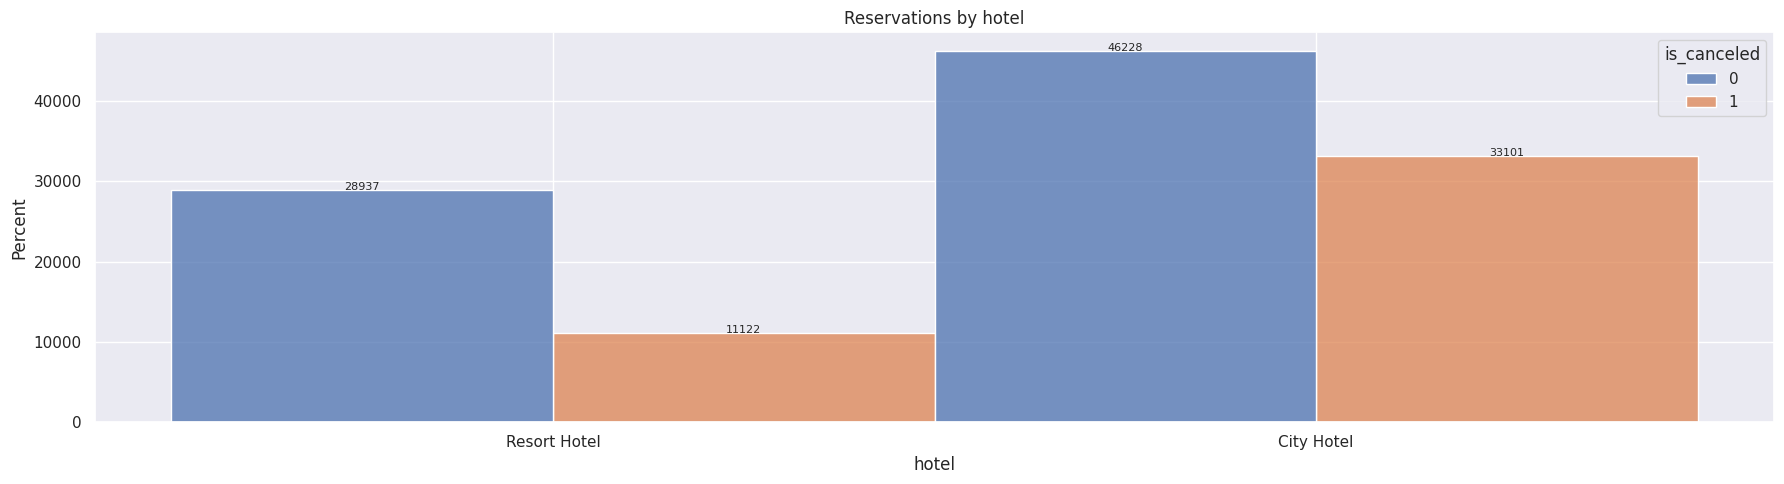

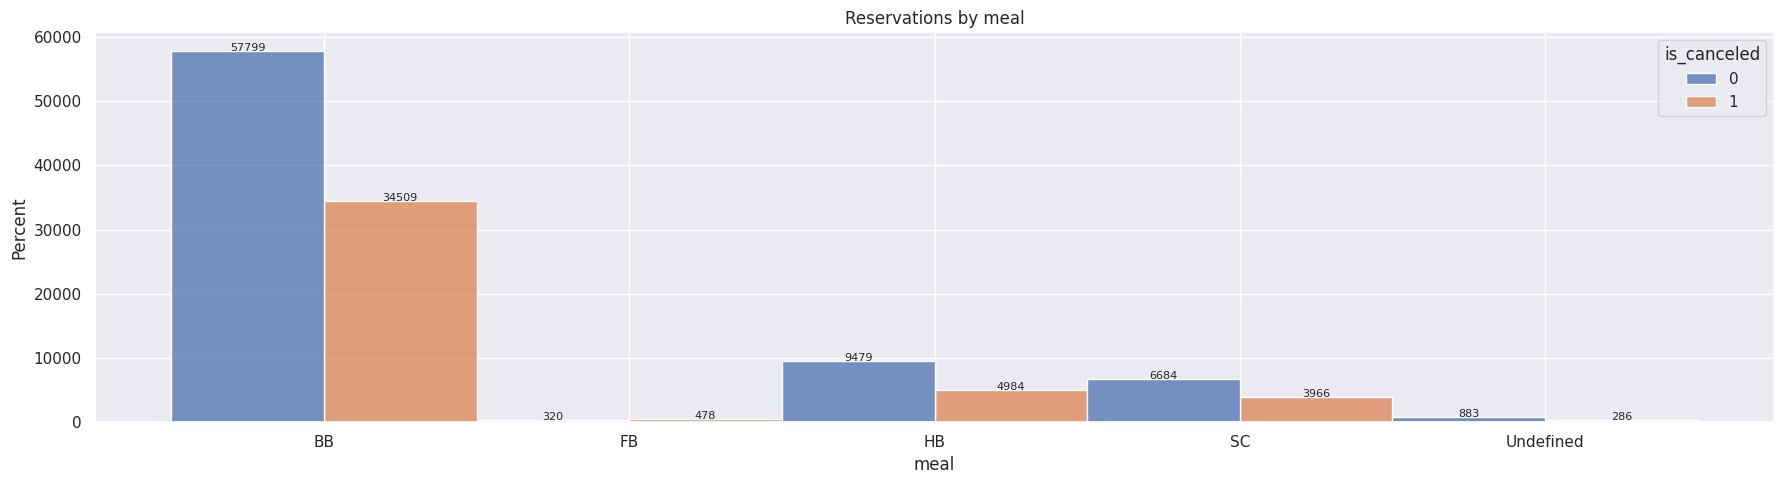

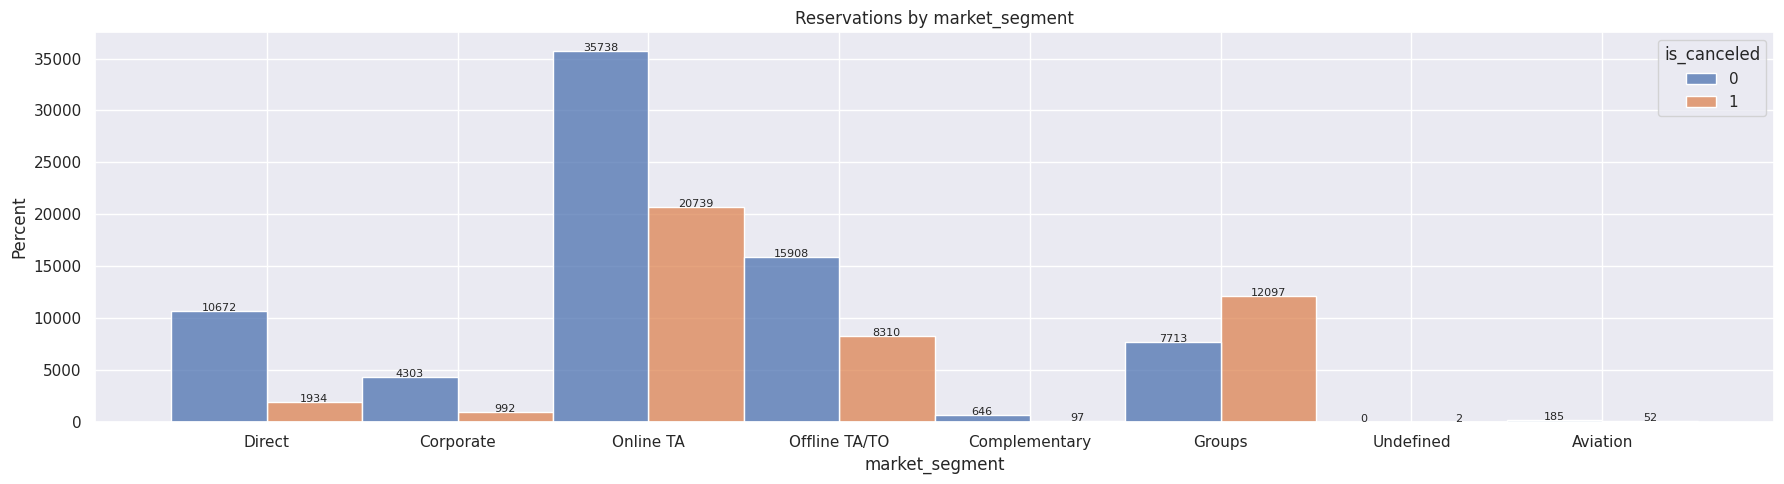

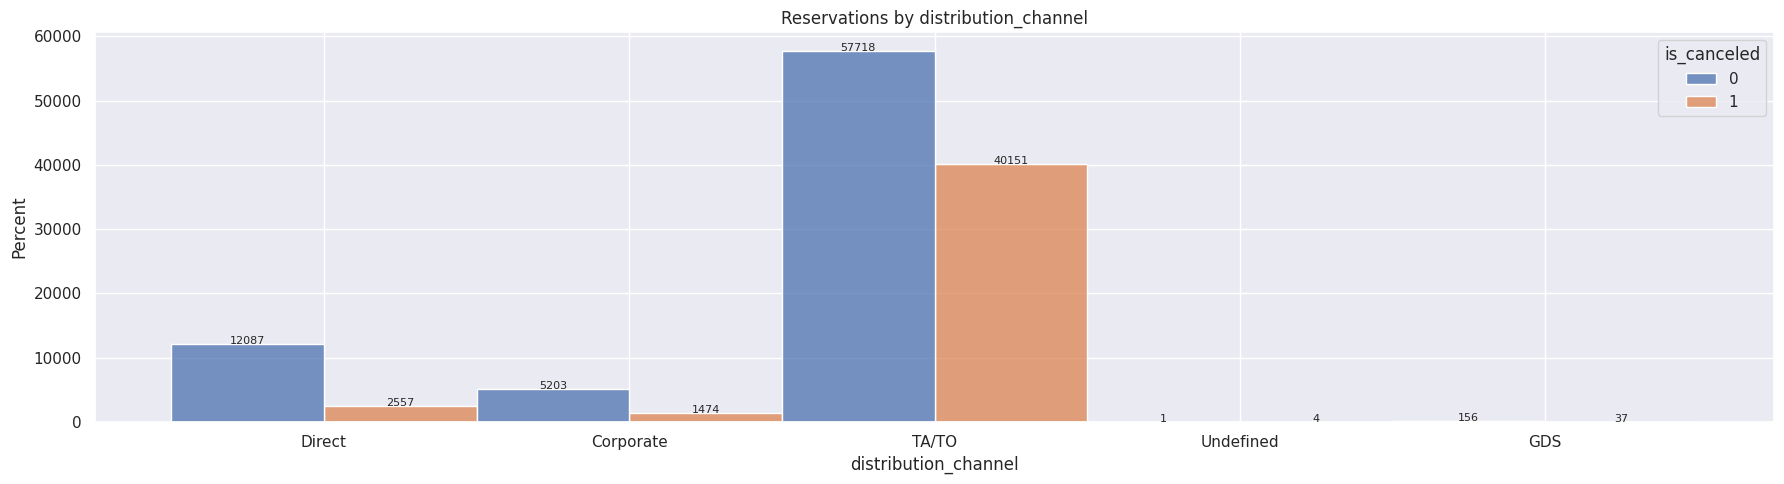

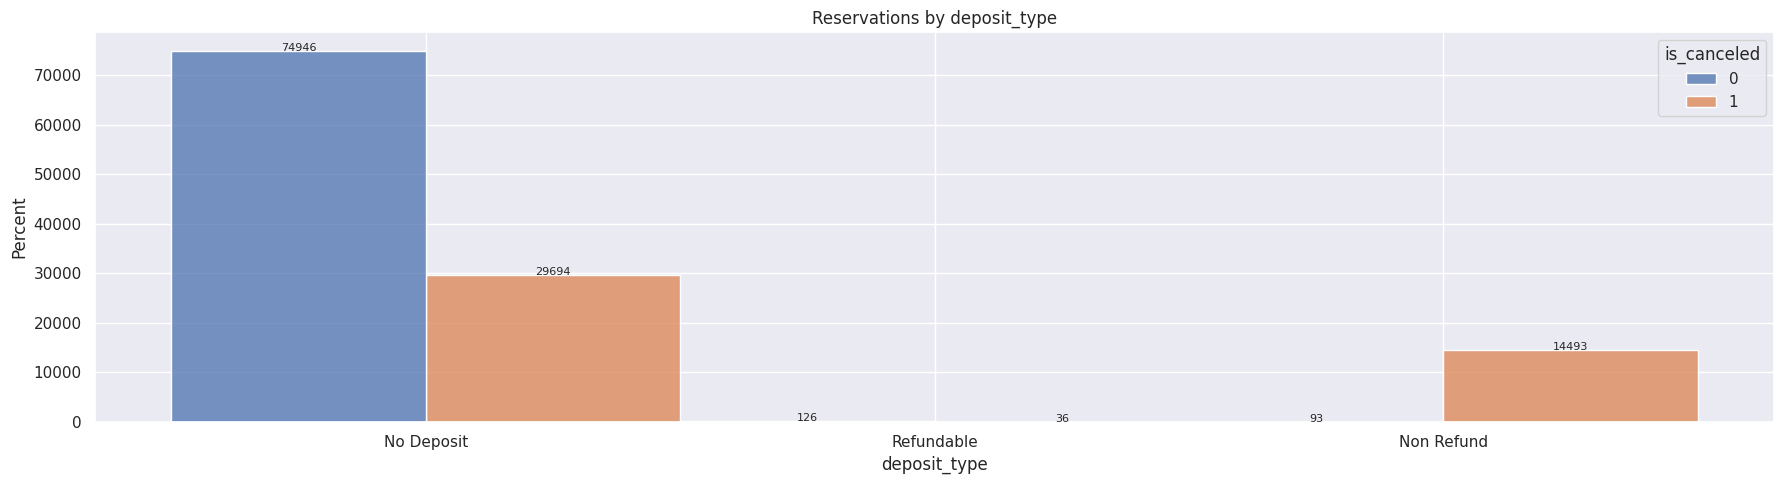

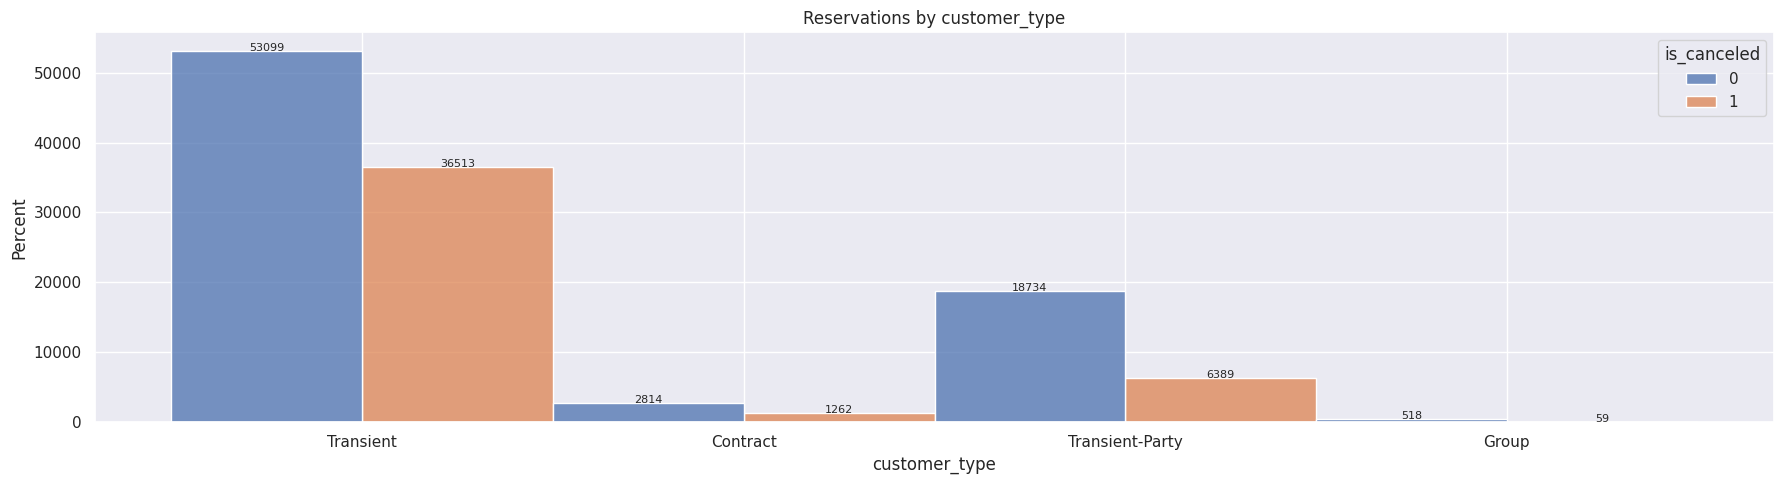

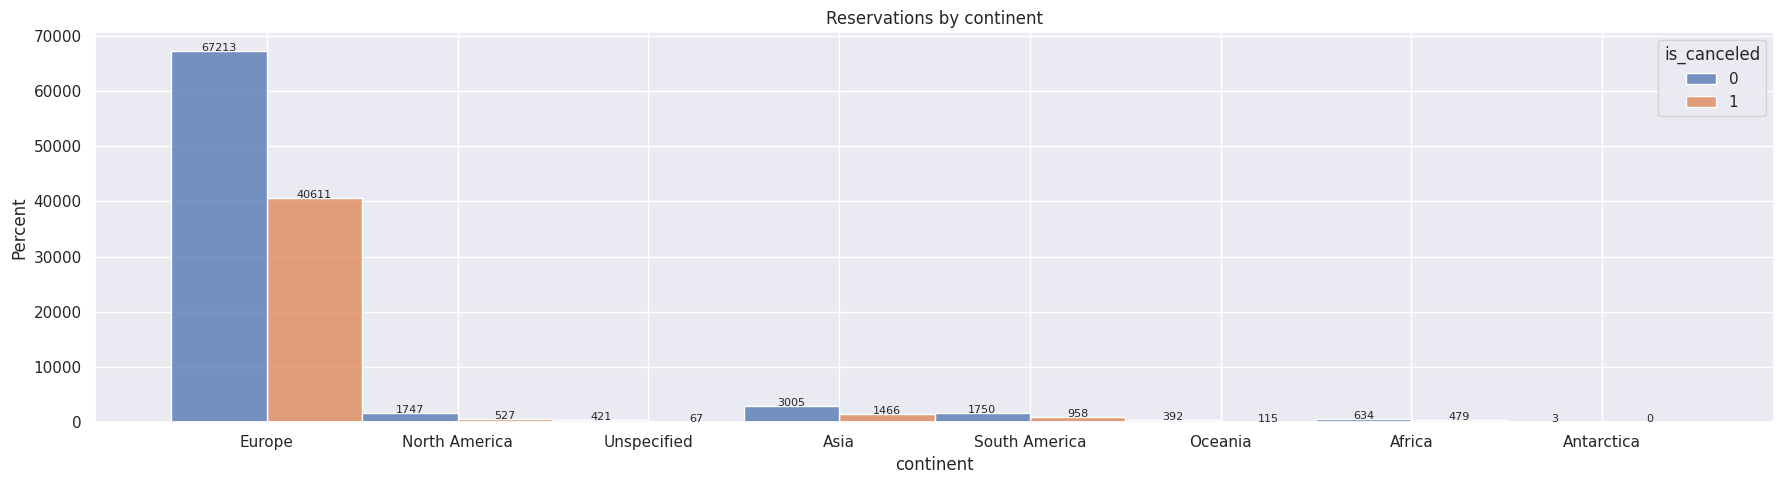

In [23]:
for col in df.select_dtypes(include='object').columns:
  plt.figure(figsize=(18, 5))
  ax = sns.histplot(
      x=col,
      data=df,
      hue='is_canceled',
      multiple='dodge'
  )

  # Add labels
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2,
            height + 0.5,
            f'{int(height)}',
            ha='center',
            fontsize=8)

  # Add title/axes
  plt.title(f'Reservations by {col}')
  plt.xlabel(f'{col}')
  plt.ylabel('Percent')
  plt.tight_layout()
  plt.show()

### Percentage of Cancellations for Each Category

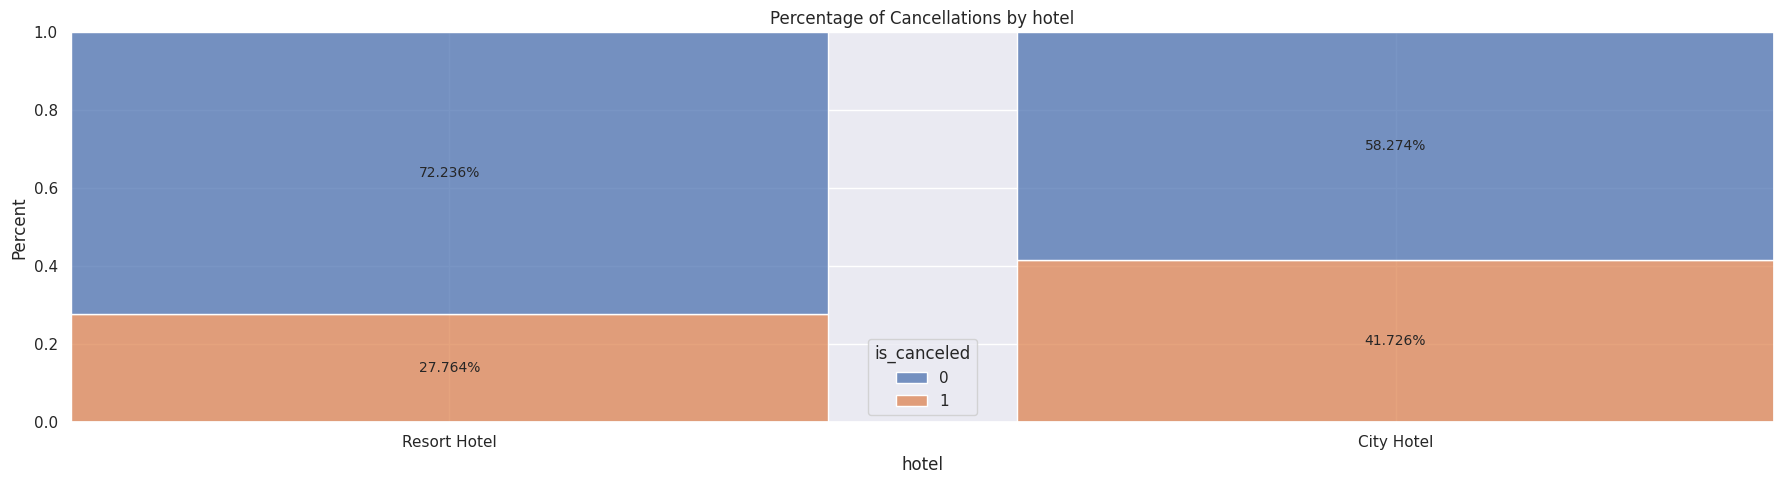

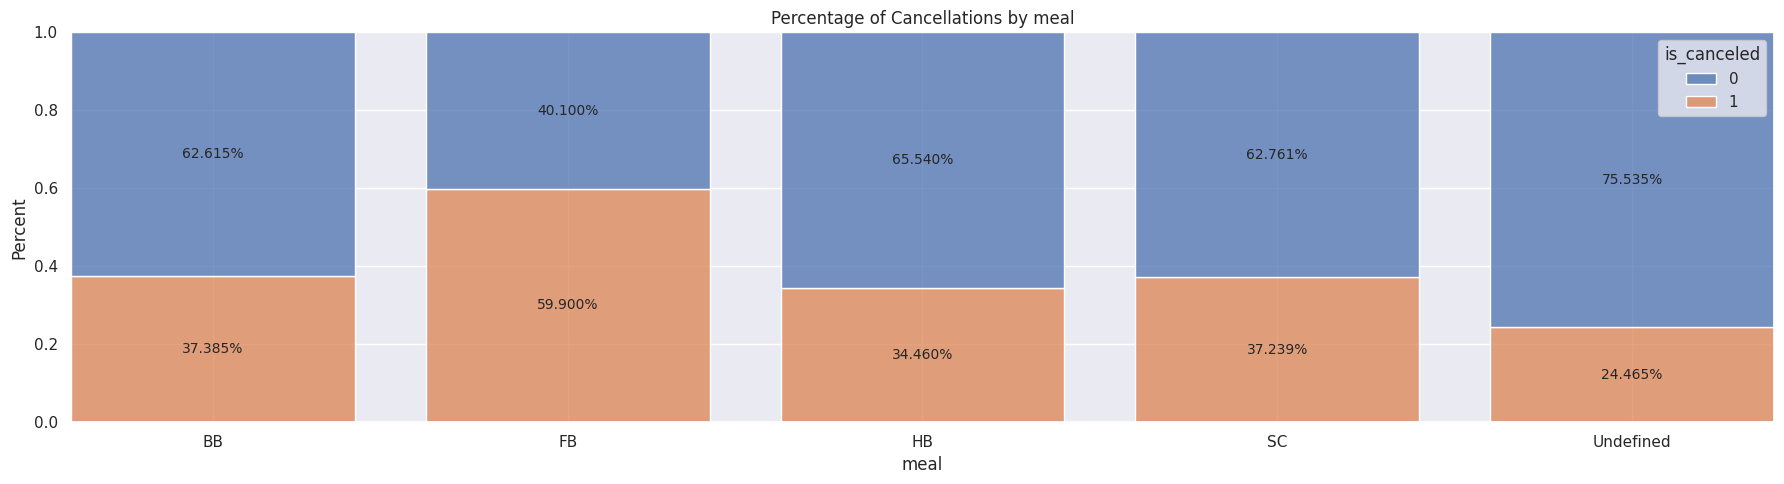

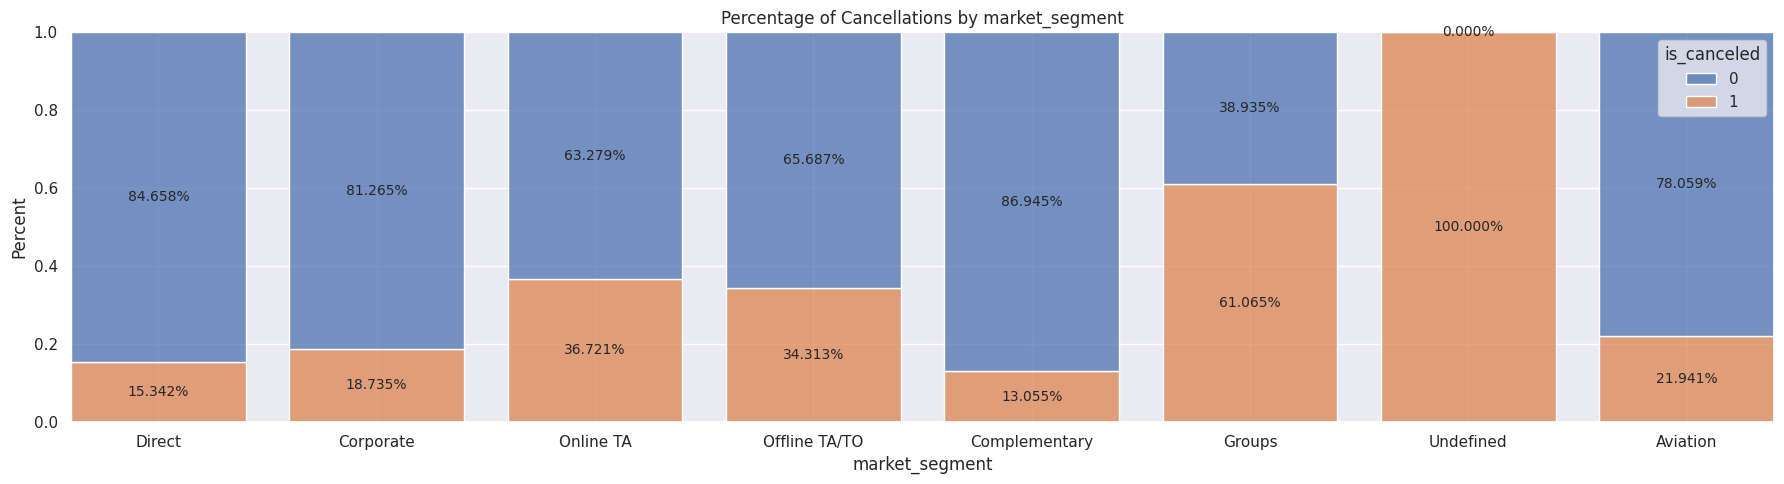

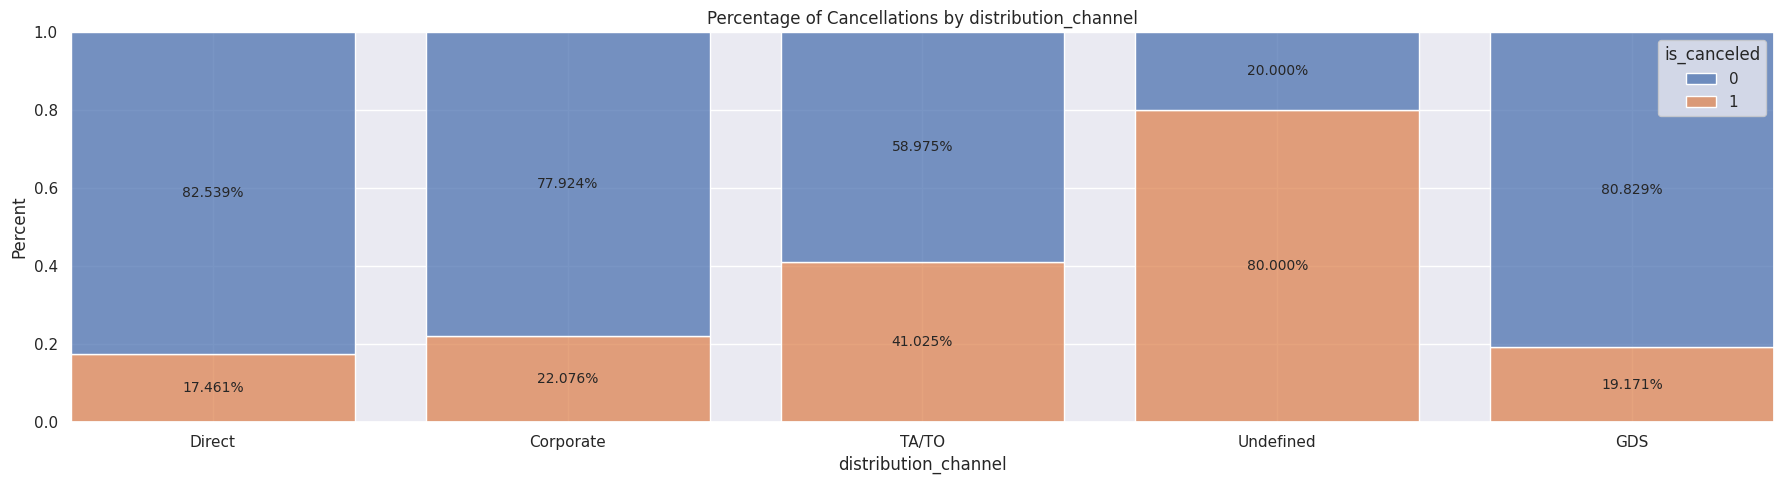

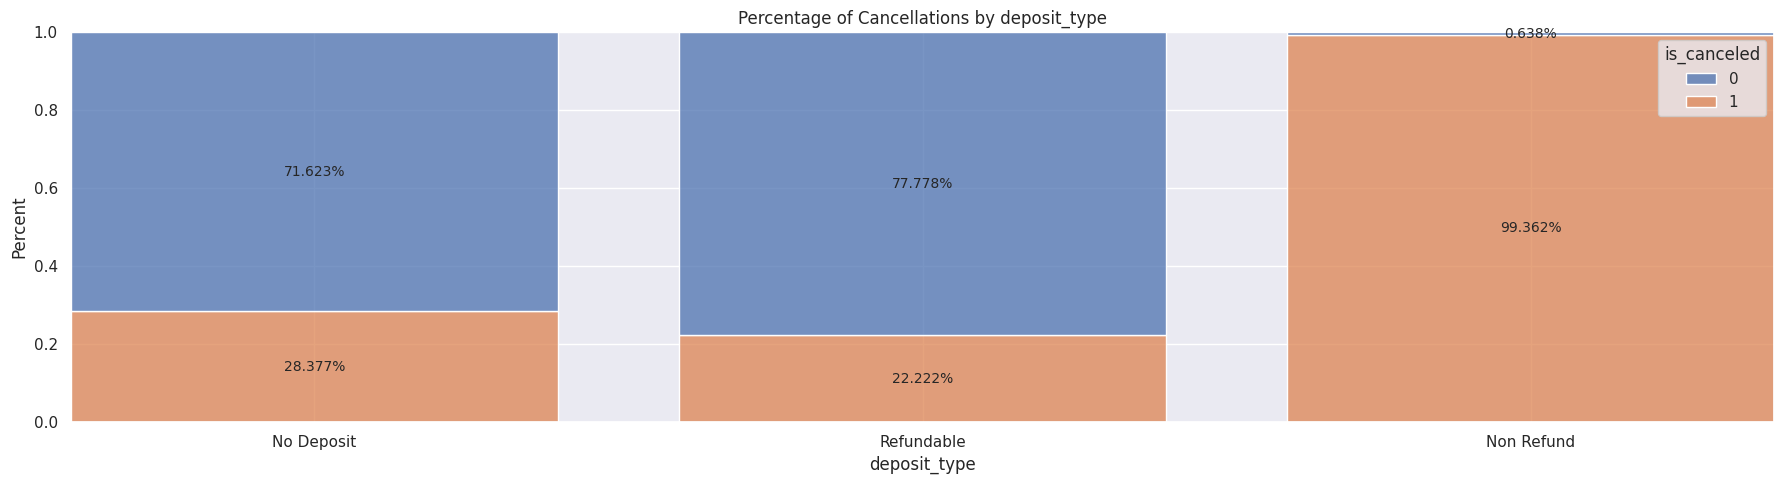

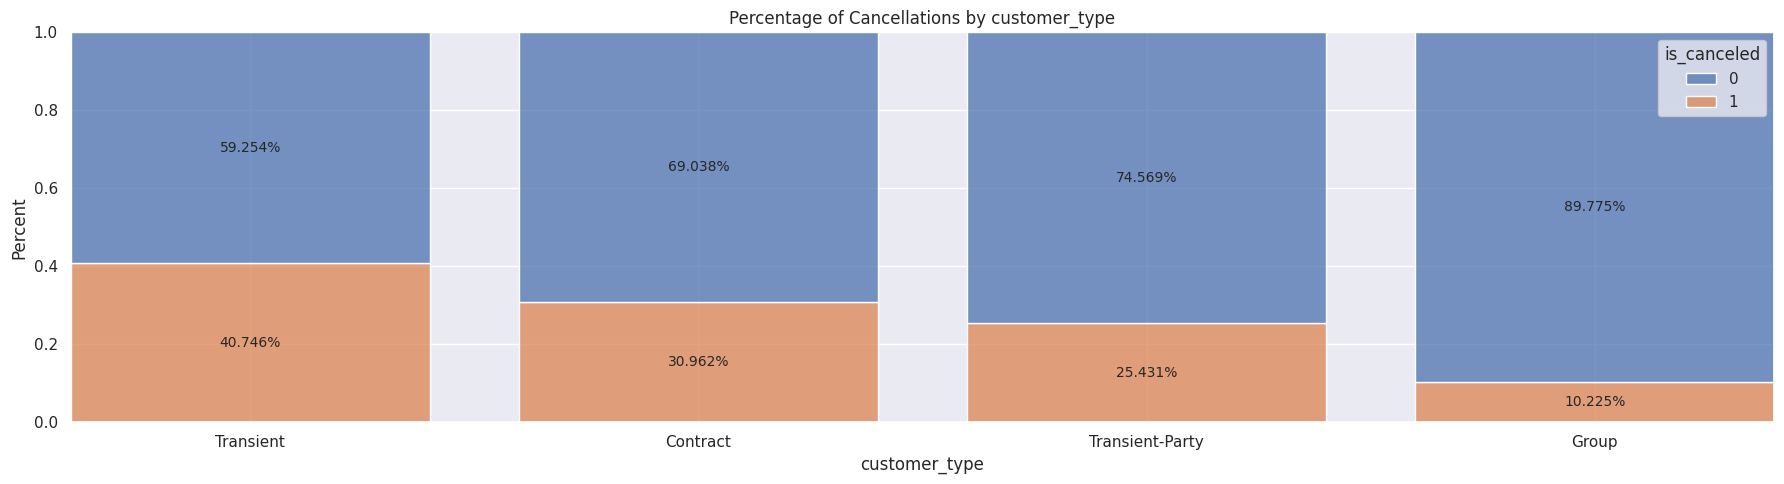

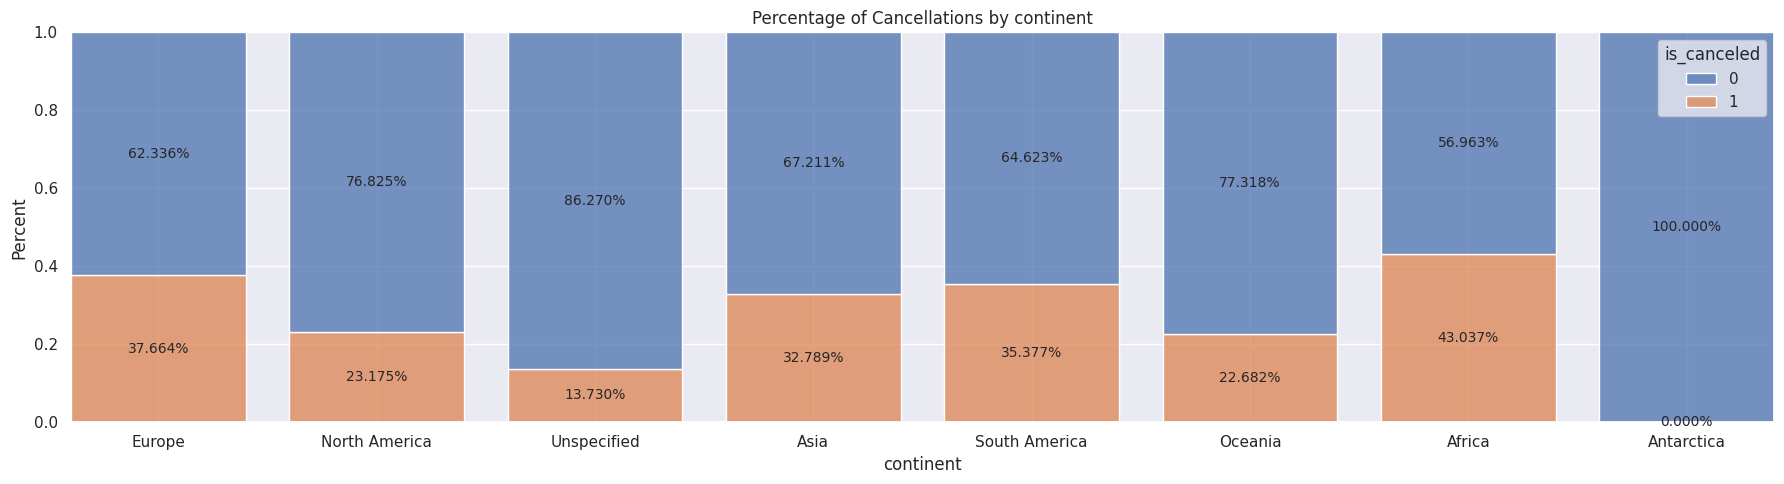

In [24]:
for col in df.select_dtypes(include='object').columns:
  plt.figure(figsize=(18, 5))
  ax = sns.histplot(
      x=col,
      data=df,
      hue='is_canceled',
      multiple='fill',
      shrink=0.8
  )

  # Add labels
  for container in ax.containers:
      labels = [f'{h * 100:.3f}%' for h in container.datavalues]
      ax.bar_label(container, labels=labels, label_type='center', fontsize=10)


  # Add title/axes
  plt.title(f'Percentage of Cancellations by {col}')
  plt.xlabel(f'{col}')
  plt.ylabel('Percent')
  plt.tight_layout()
  plt.show()

### Most Common Values for Each Column

In [25]:
print("Most common values:\n")
for col in df.columns:
  values = df[col].value_counts(normalize=True) * 100
  common_value = values.index[0]
  highest_pct = values.iloc[0]
  print(f"{col}: {common_value} ({highest_pct:.2f}%)")

Most common values:

hotel: City Hotel (66.45%)
is_canceled: 0 (62.96%)
lead_time: 0 (5.31%)
arrival_date_month: 8 (11.62%)
stays_in_weekend_nights: 0 (43.55%)
stays_in_week_nights: 2 (28.21%)
adults: 2 (75.11%)
children: 0.0 (92.80%)
babies: 0 (99.23%)
meal: BB (77.32%)
market_segment: Online TA (47.31%)
distribution_channel: TA/TO (81.98%)
is_repeated_guest: 0 (96.81%)
previous_cancellations: 0 (94.57%)
previous_bookings_not_canceled: 0 (96.97%)
booking_changes: 0 (84.86%)
deposit_type: No Deposit (87.65%)
agent: 1 (86.31%)
company: 0 (94.31%)
days_in_waiting_list: 0 (96.90%)
customer_type: Transient (75.06%)
adr: 62.0 (3.14%)
required_car_parking_spaces: 0 (93.79%)
total_of_special_requests: 0 (58.90%)
continent: Europe (90.31%)
is_reserved_room_type: 1 (87.51%)


### Hist Distribution of Each Column

### Histplot Notes:

##### Hotel data profiling
- 2/3 of data are for city hotel, 1/3 for resort hotel
- High % of cancellations
- Most data is right skewed
- Most reservations are in the middle of the year/summer
- Longer week night stays than weekend nights (expected)
- Mostly few adults + children + babies
- Bed & Breakfast is the popular selection for meals (if chosen)

##### Interesting observations
- Online TA (travel agent) is used the most in market segment; TA/TO (travel operator) has the highest distribution channel - seems to go hand in hand with agent column
- Not many repeated guests or previous cancellations, same with previous bookings not cancelled
- Most reservations were made without deposit and by transient customers (short term stays)
- Most customers are European
- Most did not have any booking changes

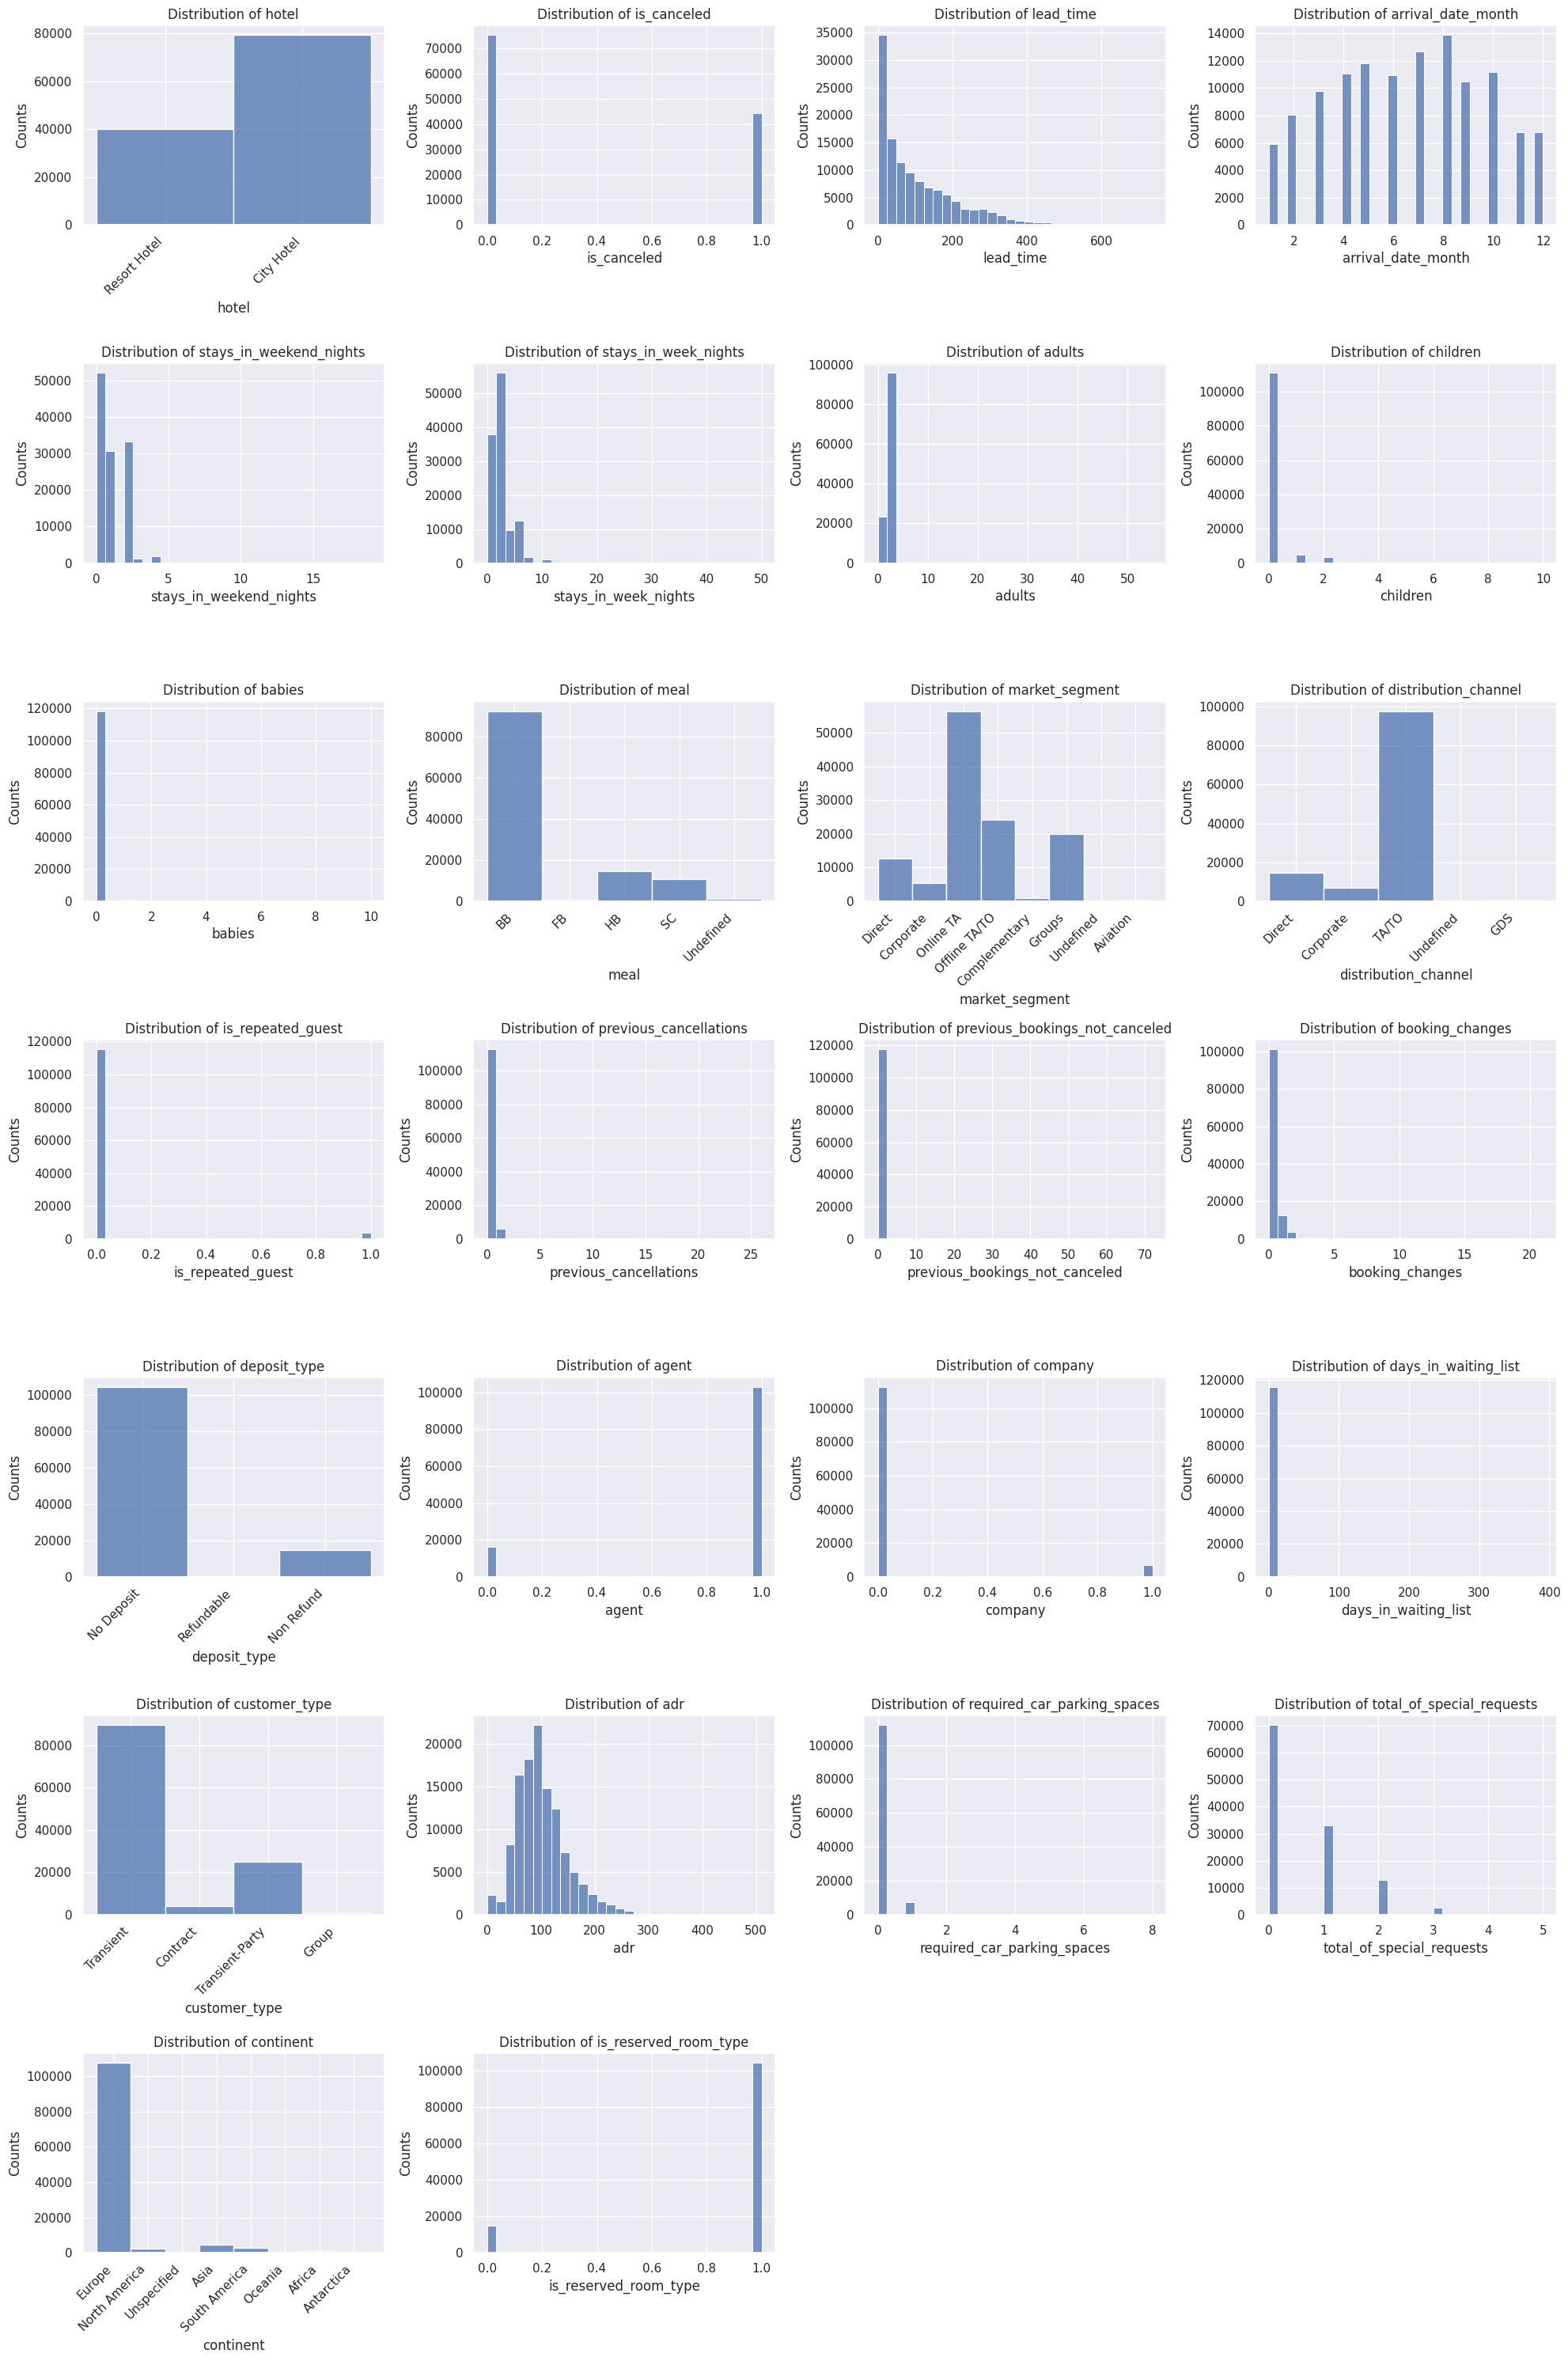

In [26]:
fig, axes = plt.subplots(7, 4, figsize=(20, 30))
axes = axes.flatten()

# Create subplot for each column
for row, col in enumerate(df.columns):
  sns.histplot(df[col], ax=axes[row], bins=30)
  axes[row].set_title(f"Distribution of {col}")
  axes[row].set_xlabel(f"{col}")
  axes[row].set_ylabel("Counts")
  if df[col].dtype == 'object':
    plt.setp(axes[row].get_xticklabels(), rotation=45, ha='right')

for i in range(len(df.columns), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Log Transformation of ADR, Lead Time, and Days in Waiting List

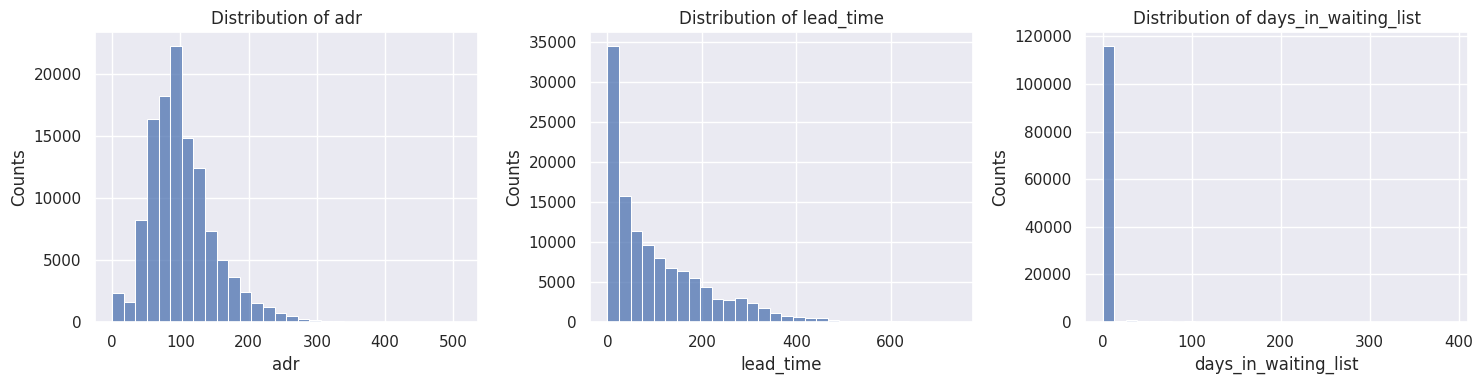

In [27]:
# Before log transformation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()
for row, col in enumerate(df[['adr','lead_time', 'days_in_waiting_list']]):
  sns.histplot(df[col], ax=axes[row], bins=30)
  axes[row].set_title(f"Distribution of {col}")
  axes[row].set_xlabel(f"{col}")
  axes[row].set_ylabel("Counts")

plt.tight_layout()
plt.show()

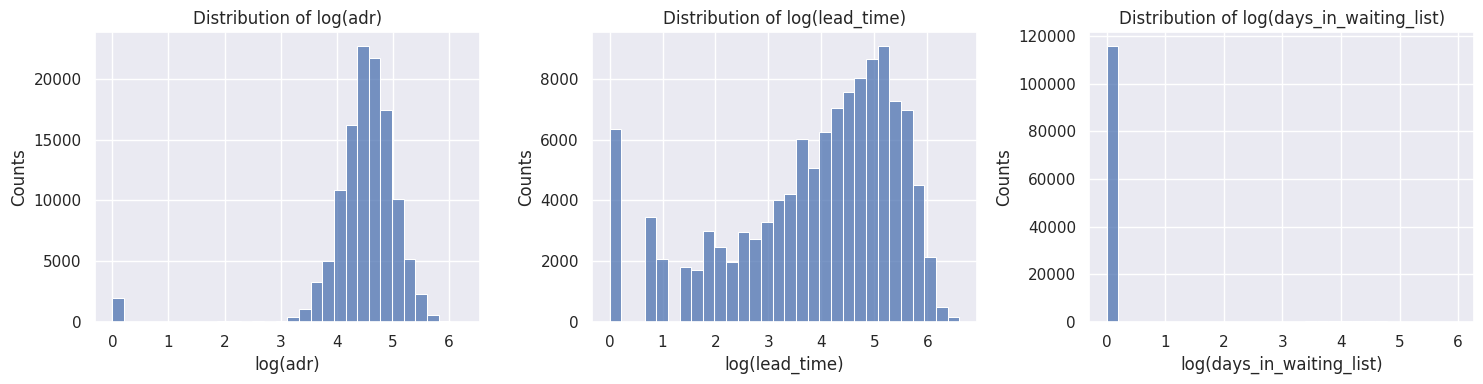

In [28]:
# After log transformation
log_cols = ['adr', 'lead_time', 'days_in_waiting_list']
log_df = df[log_cols].apply(lambda x: np.log1p(x))
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()

# Create subplot for each column
for row, col in enumerate(log_df):
  sns.histplot(log_df[col], ax=axes[row], bins=30)
  axes[row].set_title(f"Distribution of log({col})")
  axes[row].set_xlabel(f"log({col})")
  axes[row].set_ylabel("Counts")

plt.tight_layout()
plt.show()

### Boxplot Distributions of Non-Categorical Columns

### Boxplot Notes:
- Lead time has a lot of outliers
- Over 10 adults seems unlikely
- 10 children and 10 babies seems unlikely
- Outliers in previous bookings not cancelled seems relatively frequent
- ADR has a record(s) with $5000+
- A year in waiting list seems unlikely, but might be a high demand hotel booking?

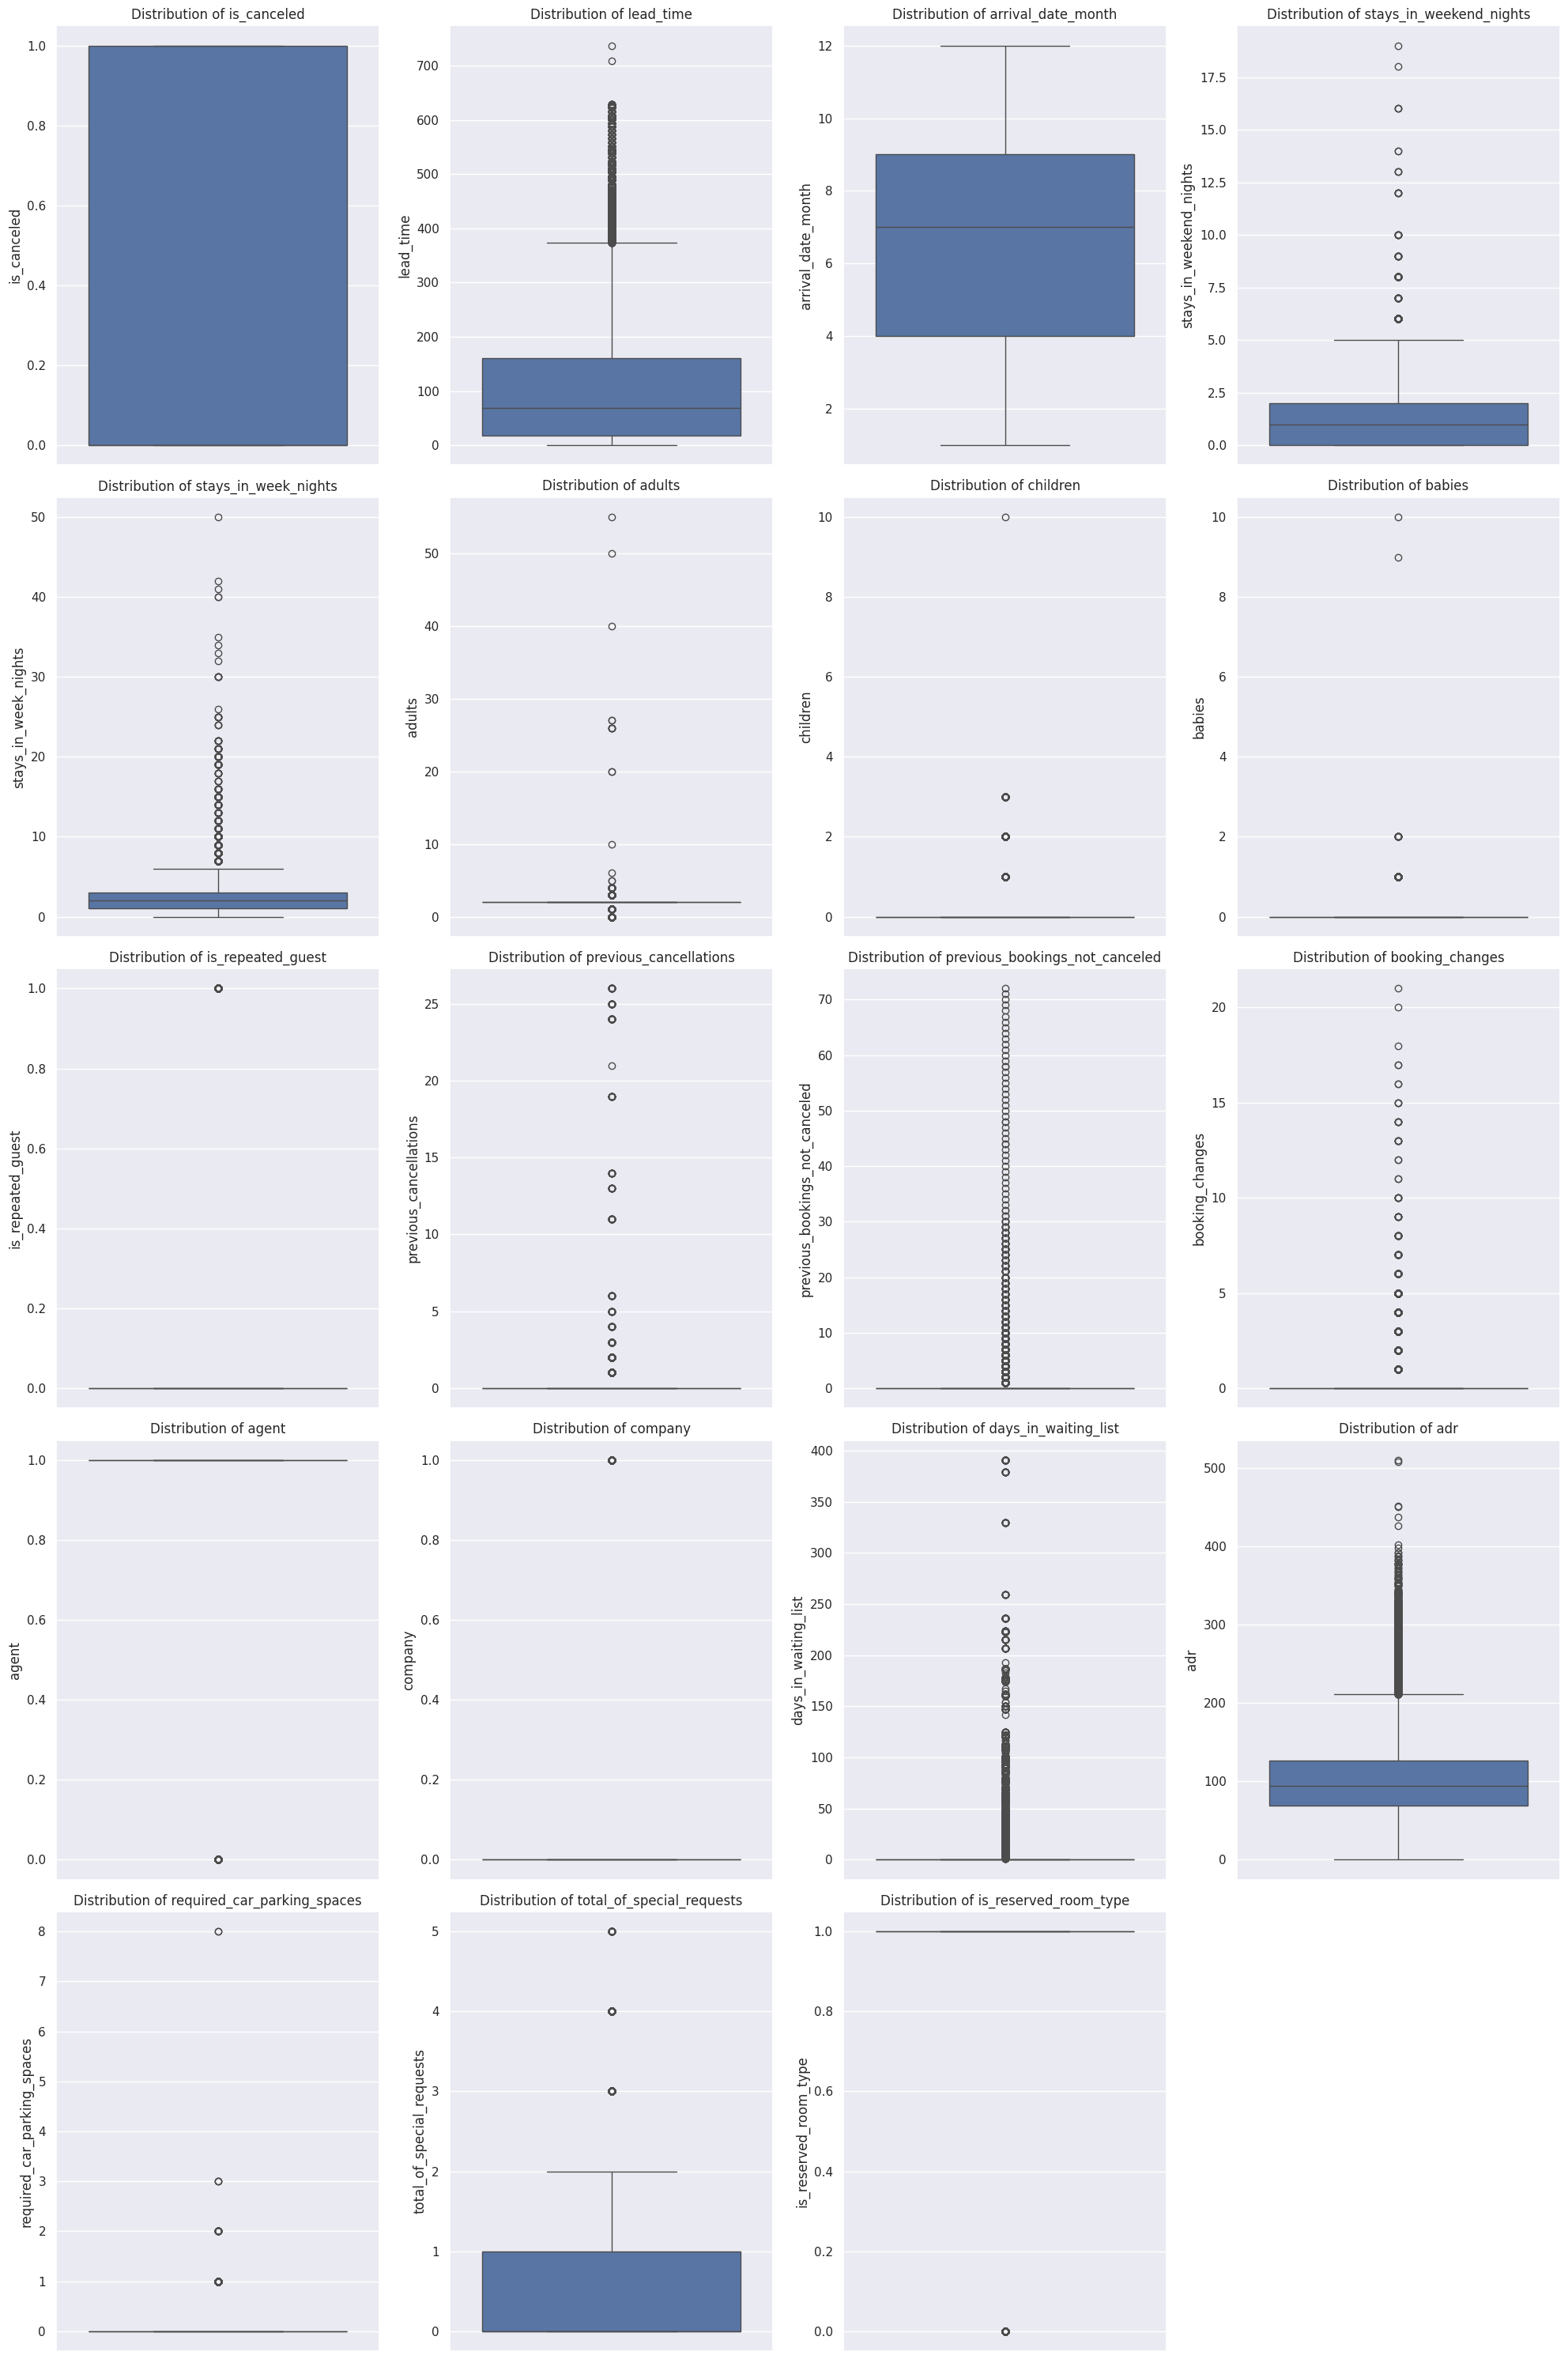

In [29]:
fig, axes = plt.subplots(5, 4, figsize=(20, 30))
axes = axes.flatten()

# Create subplot for each column
for row, col in enumerate(df.select_dtypes(exclude='object').columns):
  sns.boxplot(df[col], ax=axes[row])
  axes[row].set_title(f"Distribution of {col}")
  axes[row].set_ylabel(f"{col}")

for i in range(len(df.select_dtypes(exclude='object').columns), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Correlation Plot / Heatmap / Matrix

### Numerical Correlation Plot Notes:

##### Top 5 negative correlated fields (ranked from highest):
1. total_of_special_requests (-0.23)
2. required_car_parking_spaces (-0.20)
3. booking_changes (-0.14)
4. is_repeated_guest (-0.08)
5. previous_bookings_not_canceled (-0.06)

##### Top 5 positive correlated fields (ranked from highest):
1. lead_time (0.29)
2. is_reserved_room_type (0.25)
3. previous_cancellations (0.11)
4. agent (0.10)
5. adults (0.06)

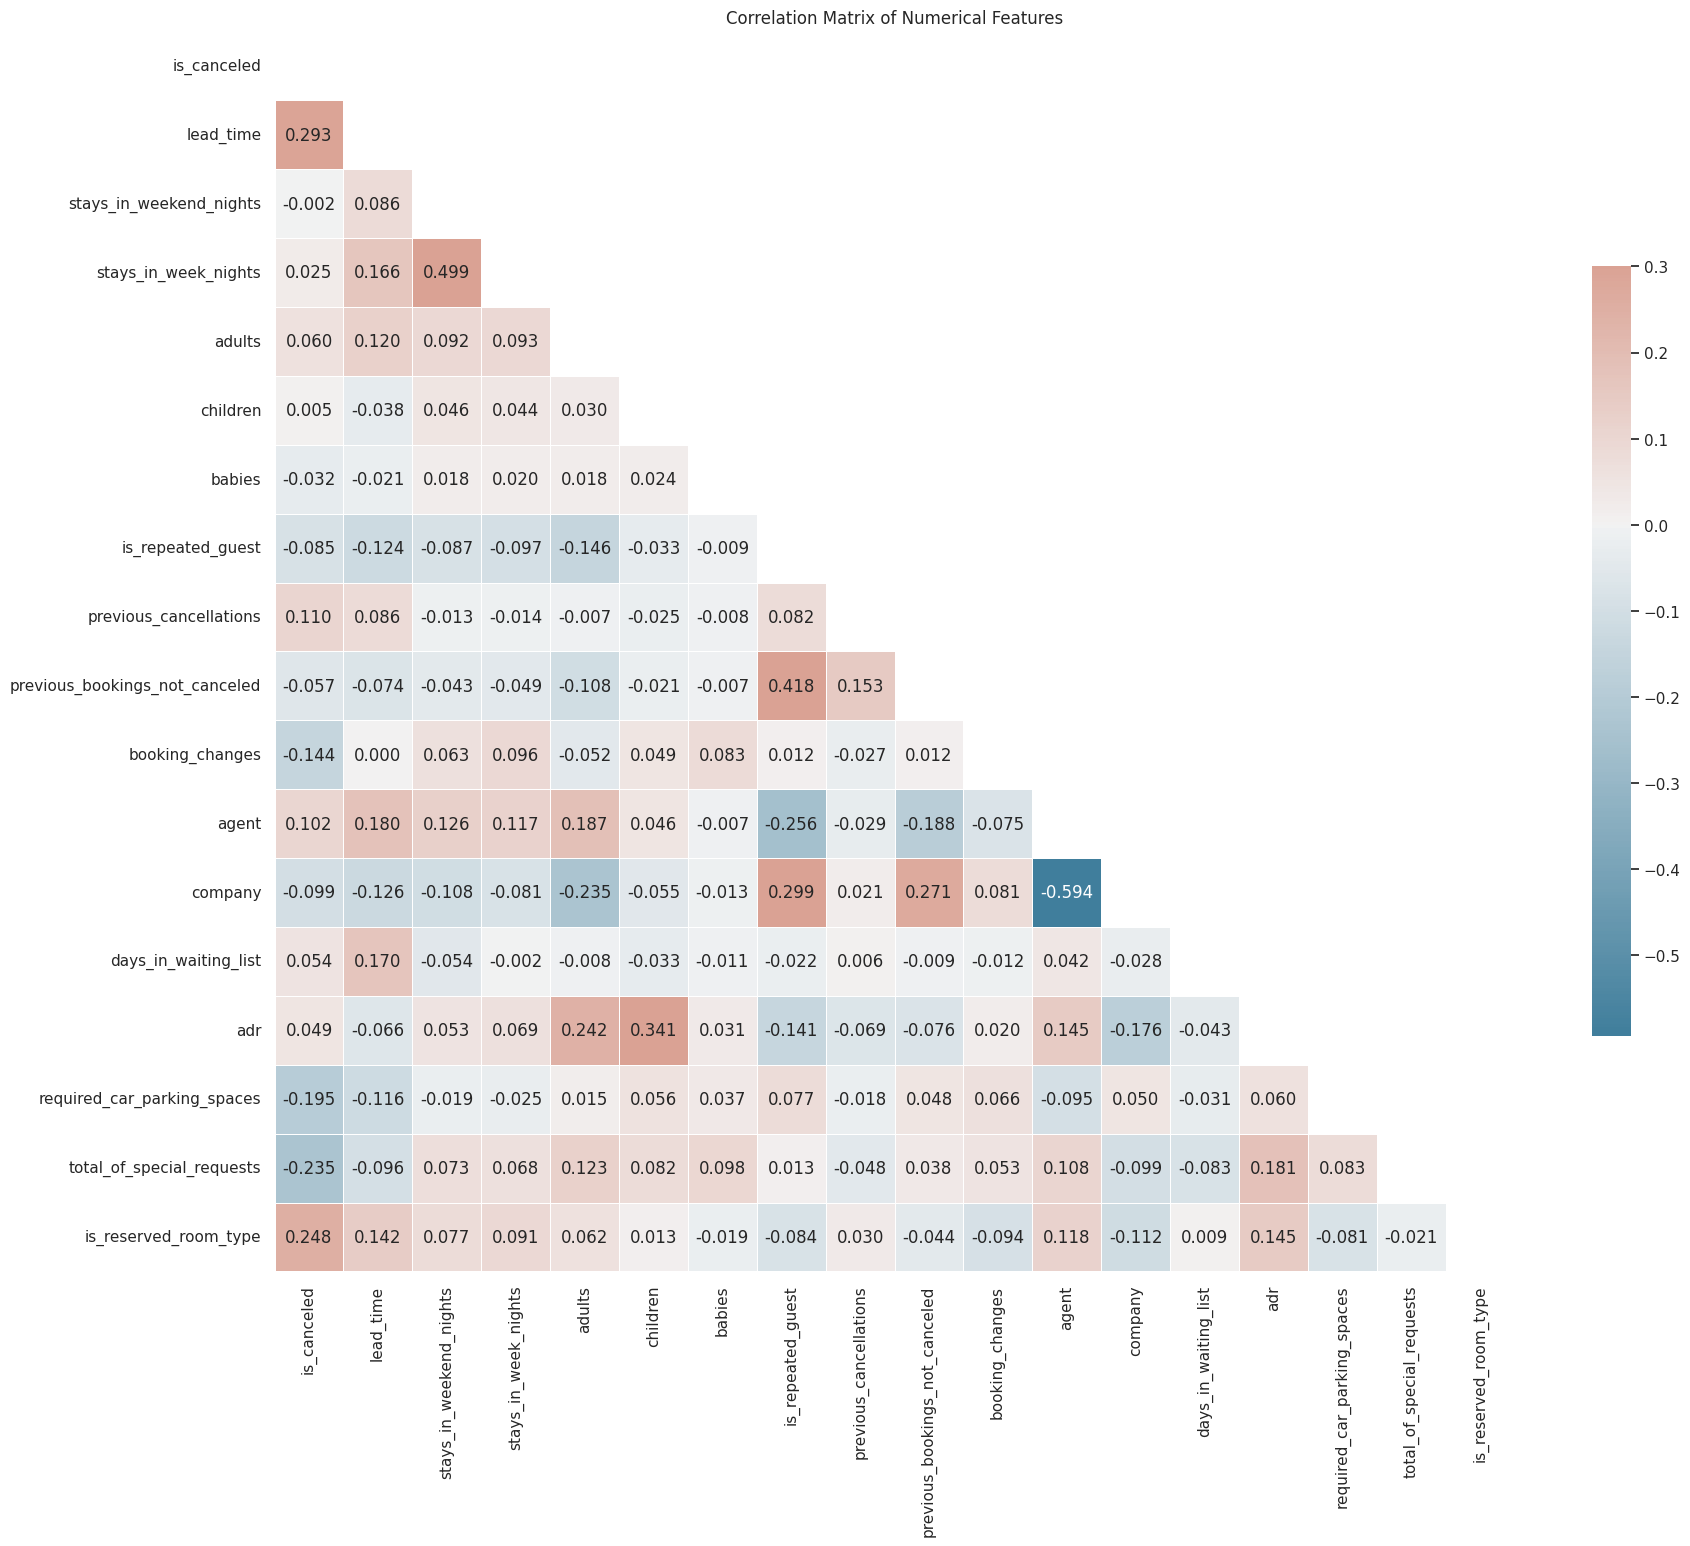

In [30]:
# Numerical Correlation Plot
sns.set_theme(style="white")
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_data = df[num_cols]

# Compute the correlation matrix
corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".3f", mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix of Numerical Features")
plt.show()

# One Hot Encoding

In [31]:
# Identify object type values for one-hot encoding
df_objects = df.select_dtypes(include=['object'])
for col in df_objects:
  print(f"{col}:\n {df_objects[col].unique()}\n")

hotel:
 ['Resort Hotel' 'City Hotel']

meal:
 ['BB' 'FB' 'HB' 'SC' 'Undefined']

market_segment:
 ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']

distribution_channel:
 ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']

deposit_type:
 ['No Deposit' 'Refundable' 'Non Refund']

customer_type:
 ['Transient' 'Contract' 'Transient-Party' 'Group']

continent:
 ['Europe' 'North America' 'Unspecified' 'Asia' 'South America' 'Oceania'
 'Africa' 'Antarctica']



In [32]:
# One-hot Encoding with Dummies
columns=df_objects.columns.to_list()
encoded_df = pd.get_dummies(df, columns=columns, prefix=columns, dtype=int)
encoded_df.head()

is_canceled  lead_time  arrival_date_month  stays_in_weekend_nights  \
0            0        342                   7                        0   
1            0        737                   7                        0   
2            0          7                   7                        0   
3            0         13                   7                        0   
4            0         14                   7                        0   

   stays_in_week_nights  adults  children  babies  is_repeated_guest  \
0                     0       2       0.0       0                  0   
1                     0       2       0.0       0                  0   
2                     1       1       0.0       0                  0   
3                     1       1       0.0       0                  0   
4                     2       2       0.0       0                  0   

   previous_cancellations  ...  customer_type_Transient  \
0                       0  ...                        1   
1                       0  ...                        1   
2                       0  ...                        1   
3                       0  ...                        1   
4                       0  ...                        1   

   customer_type_Transient-Party  continent_Africa  continent_Antarctica  \
0                              0                 0                     0   
1                              0                 0                     0   
2                              0                 0                     0   
3                              0                 0                     0   
4                              0                 0                     0   

   continent_Asia  continent_Europe  continent_North America  \
0               0                 1                        0   
1               0                 1                        0   
2               0                 1                        0   
3               0                 1                        0   
4               0                 1                        0   

   continent_Oceania  continent_South America  continent_Unspecified  
0                  0                        0                      0  
1                  0                        0                      0  
2                  0                        0                      0  
3                  0                        0                      0  
4                  0                        0                      0  

[5 rows x 54 columns]

In [33]:
# Undo one-hot encoding for categorical correlation matrix
df = encoded_df.copy()
prefixes = ['customer_type','deposit_type','distribution_channel','hotel','market_segment','meal','continent']
for prefix in prefixes:
    cols = [col for col in df.columns if col.startswith(prefix + "_")]

    if cols:
        df[prefix] = df[cols].idxmax(axis=1).str[len(prefix) + 1:]
        df.drop(columns=cols, inplace=True)

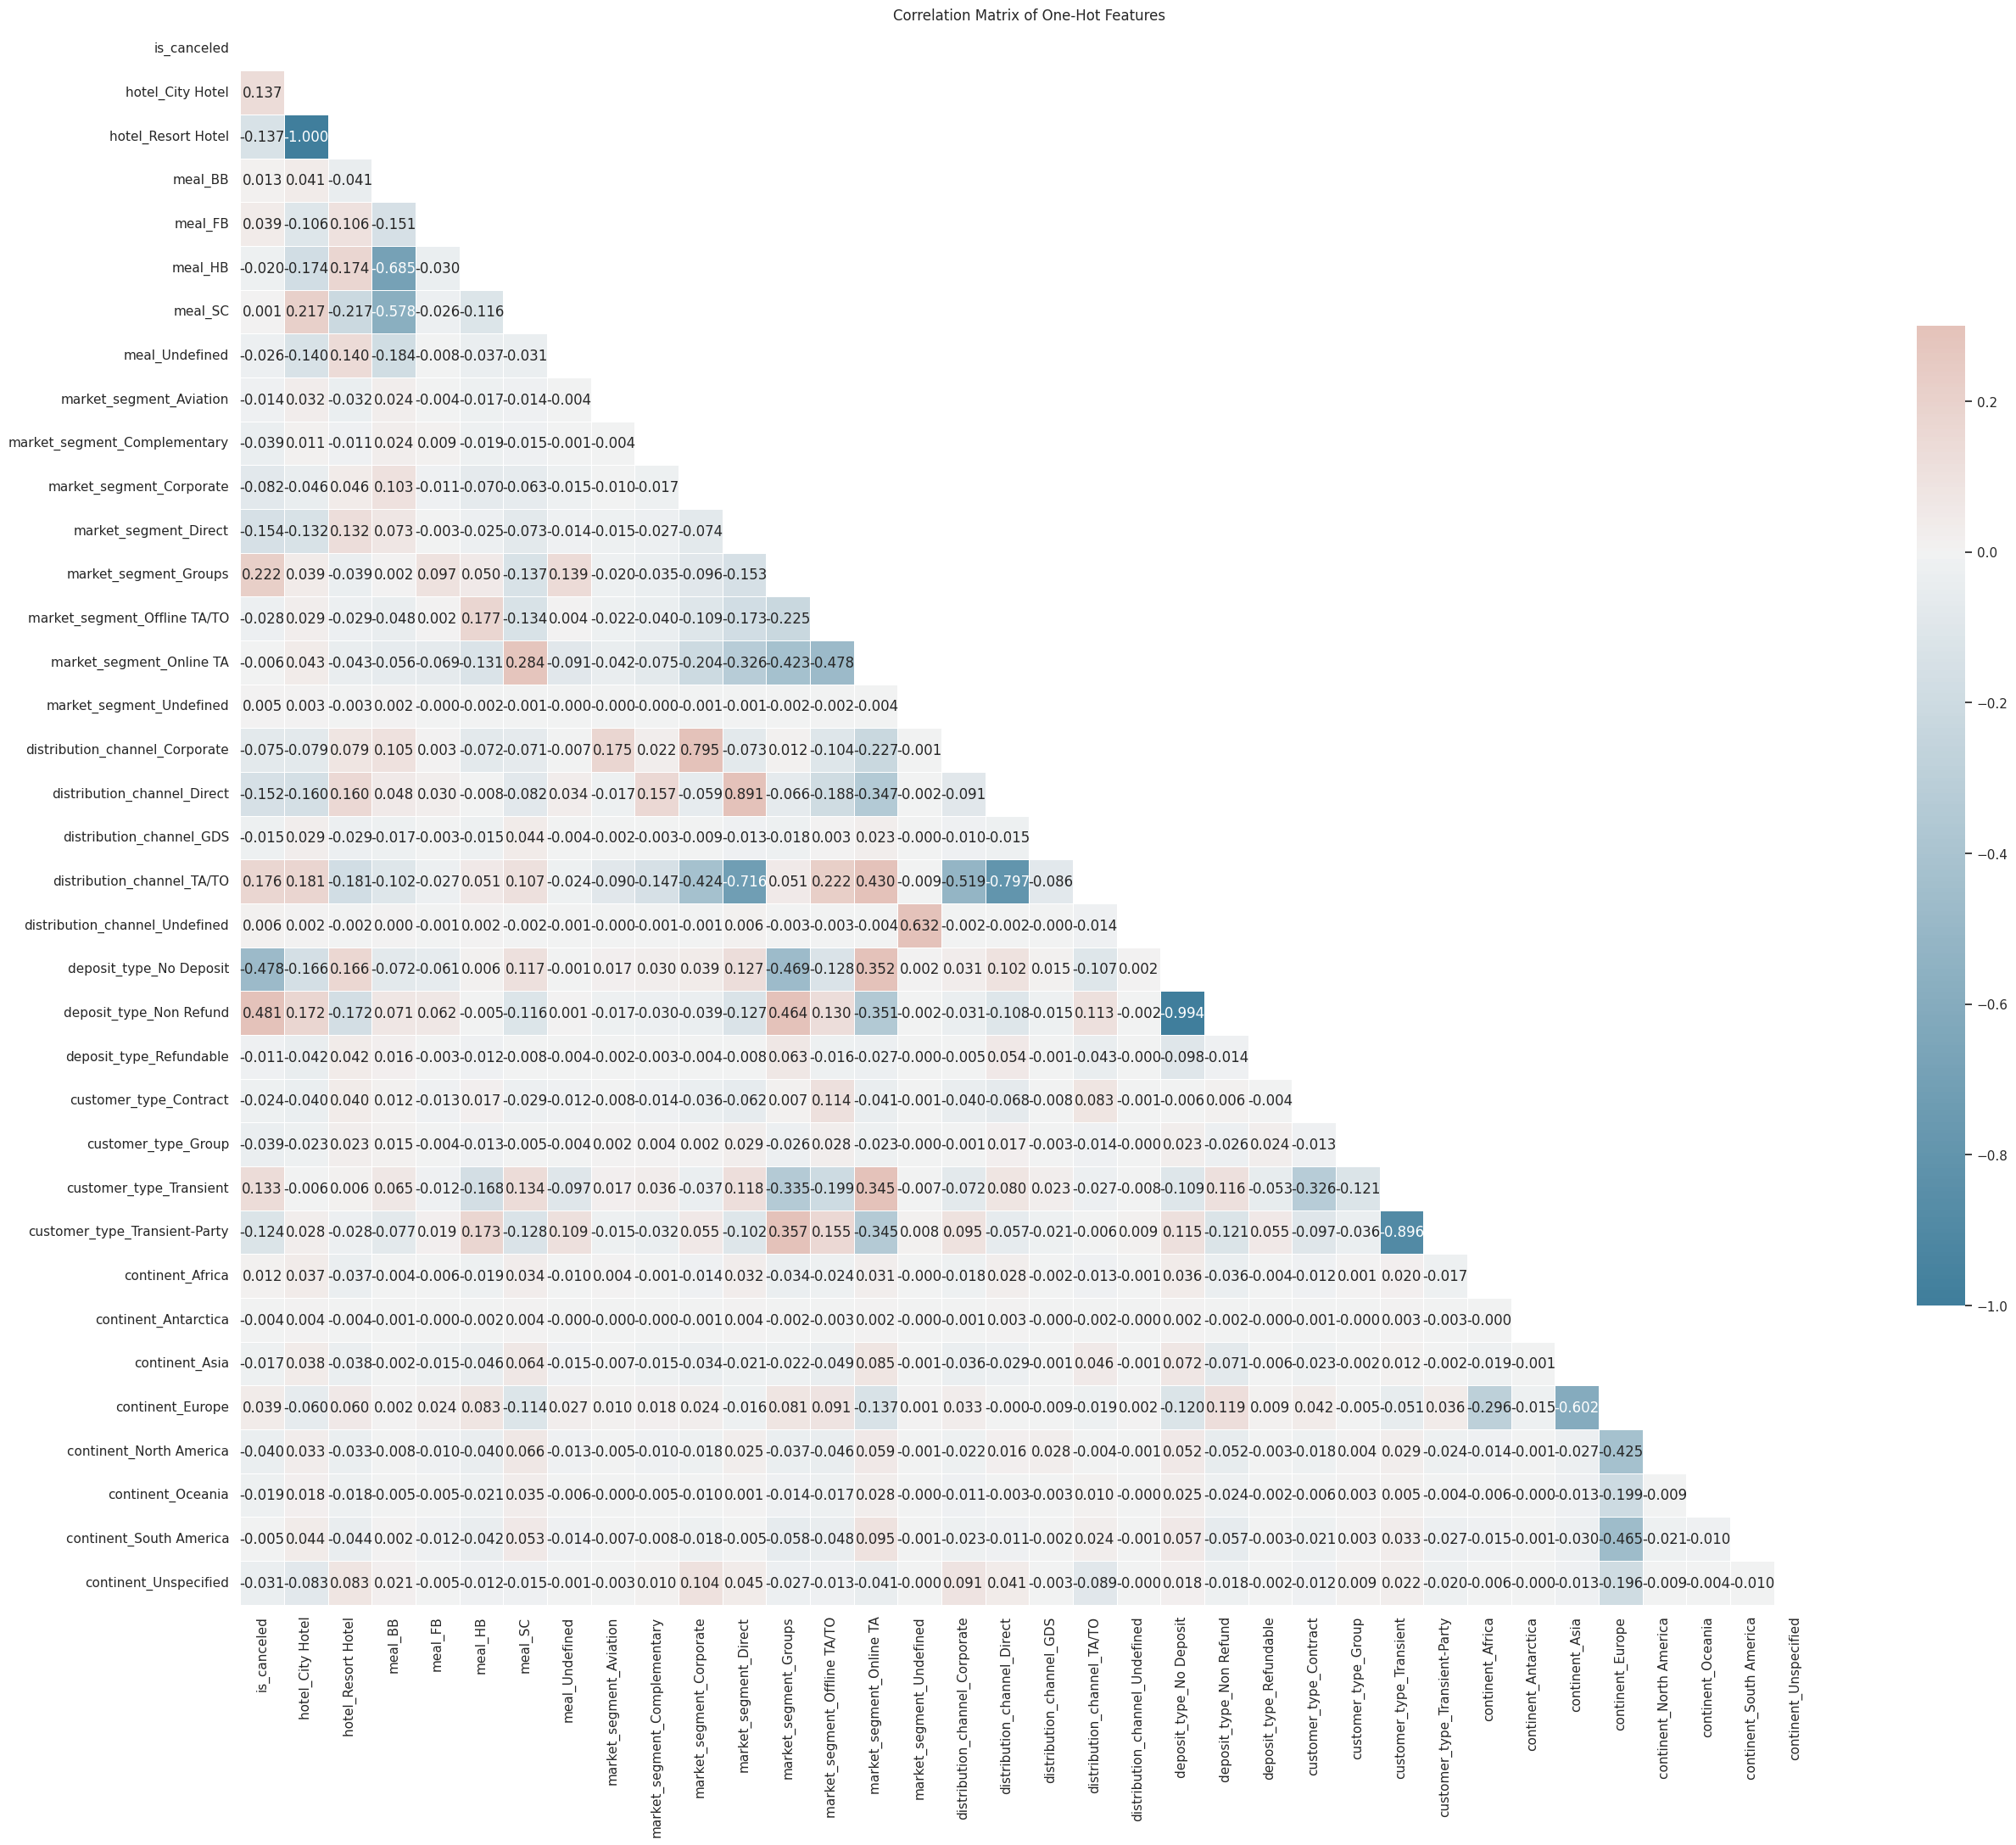

In [34]:
# List of all one-hot features
regexes = ['customer_type', 'deposit_type', 'distribution_channel', 'market_segment', 'meal', 'hotel', 'continent']
cols_to_drop = encoded_df.filter(regex='|'.join(regexes)).columns

# Create figure and df
plt.figure(figsize=(30, 30))
df_one_hot = pd.concat([encoded_df['is_canceled'], encoded_df[cols_to_drop]], axis=1)

# Compute correlation matrix with mask for upper triangle
hm = sns.heatmap(df_one_hot.corr(), annot=True, fmt=".3f", mask=np.triu(np.ones_like(df_one_hot.corr(), dtype=bool)), cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix of One-Hot Features")
plt.show()

### Shuffling and Splitting Data into 60 (Train) / 20 (Val) / 20 (Test)

In [35]:
np.random.seed(42)
# Create list of indices
indices = encoded_df.index.tolist()
# print(f"List of indices: {indices}\n")

# Shuffle indices
shuffled_indices = np.random.permutation(indices)
# print(f"Shuffled indices: {shuffled_indices}\n")

# Reindex car_data
encoded_df = encoded_df.reindex(index=shuffled_indices).reset_index(drop=True)
encoded_df.head()

is_canceled  lead_time  arrival_date_month  stays_in_weekend_nights  \
0            0        102                  12                        0   
1            1        107                   7                        0   
2            0         78                   4                        1   
3            1        162                   5                        2   
4            0         70                   4                        2   

   stays_in_week_nights  adults  children  babies  is_repeated_guest  \
0                     0       2       0.0       0                  0   
1                     2       1       0.0       0                  0   
2                     3       2       1.0       0                  0   
3                     1       1       0.0       0                  0   
4                     2       2       0.0       0                  0   

   previous_cancellations  ...  customer_type_Transient  \
0                       0  ...                        1   
1                       0  ...                        1   
2                       0  ...                        1   
3                       0  ...                        1   
4                       0  ...                        1   

   customer_type_Transient-Party  continent_Africa  continent_Antarctica  \
0                              0                 0                     0   
1                              0                 0                     0   
2                              0                 0                     0   
3                              0                 0                     0   
4                              0                 0                     0   

   continent_Asia  continent_Europe  continent_North America  \
0               0                 1                        0   
1               0                 1                        0   
2               0                 1                        0   
3               0                 1                        0   
4               0                 1                        0   

   continent_Oceania  continent_South America  continent_Unspecified  
0                  0                        0                      0  
1                  0                        0                      0  
2                  0                        0                      0  
3                  0                        0                      0  
4                  0                        0                      0  

[5 rows x 54 columns]

In [36]:
# Proportion of records that are cancelled
not_cxl = encoded_df.is_canceled.value_counts()[0]
cxl = encoded_df.is_canceled.value_counts()[1]
cxl_pct = cxl / (cxl + not_cxl)
cxl_pct.item()

0.37041411197105234

In [37]:
# Y Dataframe
Y = encoded_df[['is_canceled']]
print(f"Shape of Y: {Y.shape}")

# X Dataframe
X = encoded_df.drop(columns=['is_canceled'])
print(f"Shape of X: {X.shape}")

Shape of Y: (119388, 1)
Shape of X: (119388, 53)


In [38]:
# Partition data into training (60%), validation (20%), and test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, shuffle=True, stratify=Y_train)

print(f"X_train shape: {X_train.shape}\n")
print(f"X_val shape: {X_val.shape}\n")
print(f"X_test shape: {X_test.shape}\n")
print(f"Y_train shape: {Y_train.shape}\n")
print(f"Y_val shape: {Y_val.shape}\n")
print(f"Y_test shape: {Y_test.shape}\n")

X_train shape: (71632, 53)

X_val shape: (23878, 53)

X_test shape: (23878, 53)

Y_train shape: (71632, 1)

Y_val shape: (23878, 1)

Y_test shape: (23878, 1)



In [39]:
not_cxl = Y_val.is_canceled.value_counts()[0]
cxl = Y_val.is_canceled.value_counts()[1]
cxl_pct = cxl / (cxl + not_cxl)
cxl_pct.item()

0.3704246586816316

In [40]:
# Checking for Quantiles
X_train.select_dtypes(include=['number']).quantile([0.25, 0.5, 0.75, 0.95])

lead_time  arrival_date_month  stays_in_weekend_nights  \
0.25       18.0                 4.0                      0.0   
0.50       69.0                 7.0                      1.0   
0.75      161.0                 9.0                      2.0   
0.95      320.0                12.0                      2.0   

      stays_in_week_nights  adults  children  babies  is_repeated_guest  \
0.25                   1.0     2.0       0.0     0.0                0.0   
0.50                   2.0     2.0       0.0     0.0                0.0   
0.75                   3.0     2.0       0.0     0.0                0.0   
0.95                   5.0     3.0       1.0     0.0                0.0   

      previous_cancellations  previous_bookings_not_canceled  ...  \
0.25                     0.0                             0.0  ...   
0.50                     0.0                             0.0  ...   
0.75                     0.0                             0.0  ...   
0.95                     1.0                             0.0  ...   

      customer_type_Transient  customer_type_Transient-Party  \
0.25                      0.0                            0.0   
0.50                      1.0                            0.0   
0.75                      1.0                            0.0   
0.95                      1.0                            1.0   

      continent_Africa  continent_Antarctica  continent_Asia  \
0.25               0.0                   0.0             0.0   
0.50               0.0                   0.0             0.0   
0.75               0.0                   0.0             0.0   
0.95               0.0                   0.0             0.0   

      continent_Europe  continent_North America  continent_Oceania  \
0.25               1.0                      0.0                0.0   
0.50               1.0                      0.0                0.0   
0.75               1.0                      0.0                0.0   
0.95               1.0                      0.0                0.0   

      continent_South America  continent_Unspecified  
0.25                      0.0                    0.0  
0.50                      0.0                    0.0  
0.75                      0.0                    0.0  
0.95                      0.0                    0.0  

[4 rows x 53 columns]

In [41]:
# Get list of all numerical type columns
numerical_cols = X_train.select_dtypes(include=['number'])
print(numerical_cols.columns.tolist())

['lead_time', 'arrival_date_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'is_reserved_room_type', 'hotel_City Hotel', 'hotel_Resort Hotel', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Aviation', 'market_segment_Complementary', 'market_segment_Corporate', 'market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'market_segment_Undefined', 'distribution_channel_Corporate', 'distribution_channel_Direct', 'distribution_channel_GDS', 'distribution_channel_TA/TO', 'distribution_channel_Undefined', 'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable', 'customer_type_Contract', 'customer_type_Group', 'customer_type_Transient', 'c

In [42]:
# Identify binary columns of dataframe
def is_binary(df):
  binary_cols = []
  for col in df.columns:
    unique_val = df[col].unique()
    if len(unique_val) == 2:
      unique_set = set(unique_val)
      if unique_set == {0,1}:
        binary_cols.append(col)
    elif len(unique_val) == 1:
      unique_set = set(unique_val)
      if unique_set == {0} or unique_set == {1}:
        binary_cols.append(col)
  return binary_cols

In [43]:
# Remove binary numerical columns to isolate columns needed to be standardized
binary_cols = is_binary(encoded_df)
date_cols = ['arrival_month_number', 'arrival_date_year','arrival_date_week_number','arrival_date_day_of_month']
non_binary_num_cols = set(numerical_cols) - set(binary_cols)

cols_to_std = list(non_binary_num_cols)
cols_to_std

['arrival_date_month',
 'babies',
 'required_car_parking_spaces',
 'previous_cancellations',
 'children',
 'stays_in_week_nights',
 'total_of_special_requests',
 'previous_bookings_not_canceled',
 'booking_changes',
 'adr',
 'lead_time',
 'days_in_waiting_list',
 'stays_in_weekend_nights',
 'adults']

# Models

### Loading Split Data

In [44]:
split_path = '/content/drive/MyDrive/Colab Notebooks/data/207_project/'
processed_df = pd.read_csv(split_path + 'hotel_bookings_processed.csv')
x_train = pd.read_csv(split_path + 'hotel_bookings_X_train.csv')
y_train = pd.read_csv(split_path + 'hotel_bookings_Y_train.csv')
x_val = pd.read_csv(split_path + 'hotel_bookings_X_val.csv')
y_val = pd.read_csv(split_path + 'hotel_bookings_Y_val.csv')
x_test = pd.read_csv(split_path + 'hotel_bookings_X_test.csv')
y_test = pd.read_csv(split_path + 'hotel_bookings_Y_test.csv')

In [45]:
x_train.head(5)

lead_time  arrival_date_month  stays_in_weekend_nights  \
0   0.708440            0.142909                 0.075267   
1  -1.517151            1.434384                -0.933251   
2   1.280678            1.111515                -0.933251   
3  -0.105551           -1.471434                 1.083786   
4   1.025938            0.142909                -0.933251   

   stays_in_week_nights    adults  children    babies  previous_cancellations  \
0              0.269363  0.247970 -0.262007 -0.078768               -0.103409   
1             -0.259920 -1.466069 -0.262007 -0.078768               -0.103409   
2              0.798646 -1.466069 -0.262007 -0.078768               -0.103409   
3              1.327929  0.247970 -0.262007 -0.078768               -0.103409   
4              0.269363  0.247970 -0.262007 -0.078768               -0.103409   

   previous_bookings_not_canceled  booking_changes  ...  meal_sc  \
0                       -0.092924        -0.340531  ...        0   
1                       -0.092924        -0.340531  ...        0   
2                       -0.092924         1.206359  ...        0   
3                       -0.092924        -0.340531  ...        0   
4                       -0.092924        -0.340531  ...        1   

   meal_undefined  continent_africa  continent_antarctica  continent_asia  \
0               0                 0                     0               0   
1               0                 0                     0               0   
2               0                 0                     0               0   
3               0                 0                     0               0   
4               0                 0                     0               0   

   continent_europe  continent_north_america  continent_oceania  \
0                 1                        0                  0   
1                 1                        0                  0   
2                 1                        0                  0   
3                 1                        0                  0   
4                 1                        0                  0   

   continent_south_america  continent_unspecified  
0                        0                      0  
1                        0                      0  
2                        0                      0  
3                        0                      0  
4                        0                      0  

[5 rows x 53 columns]

### Random Forest Classifier

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Train Pred Accuracy: 0.853

Random Forest Val Pred Accuracy: 0.844

Train Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89     45099
           1       0.88      0.69      0.78     26533

    accuracy                           0.85     71632
   macro avg       0.86      0.82      0.83     71632
weighted avg       0.86      0.85      0.85     71632

Val Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88     15033
           1       0.87      0.68      0.76      8845

    accuracy                           0.84     23878
   macro avg       0.85      0.81      0.82     23878
weighted avg       0.85      0.84      0.84     23878



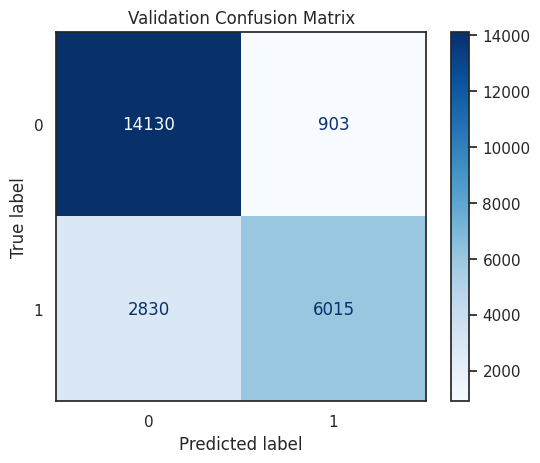

In [46]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=5) #n_estimators=200, n_jobs=-1, random_state=7, max_depth=15, max_features=16, min_samples_leaf=20

# Fit train and predict
rfc_model = rfc.fit(x_train, y_train)
rfc_train_pred = rfc_model.predict(x_train)
rfc_val_pred = rfc_model.predict(x_val)
rfc_test_pred = rfc_model.predict(x_test)

# Evaluate accuracy
train_accuracy = accuracy_score(y_train, rfc_train_pred)
val_accuracy = accuracy_score(y_val, rfc_val_pred)
print(f"Random Forest Train Pred Accuracy: {train_accuracy:.3f}\n")
print(f"Random Forest Val Pred Accuracy: {val_accuracy:.3f}\n")

# Classification Report
print('Train Classification Report:\n', classification_report(y_train, rfc_train_pred))
print('Val Classification Report:\n', classification_report(y_val, rfc_val_pred))

# Create confusion matrix with labels/colors
conf_matrix = confusion_matrix(y_val, rfc_val_pred)
c_matrix = ConfusionMatrixDisplay(conf_matrix)
c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.show()

##### RFC Tests

model # | n_estimators | n_jobs | random_state | max_depth | max_features | min_samples_leaf | train_acc | val acc
-|-|-|-|-|-|-|-|-|
1 | 10 | -1 | 7 | 8 | - | - | 0.802 | 0.801
2 | 10 | -1 | 7 | 8 | 10 | - | 0.807 | 0.807
3 | 100 | -1 | 7 | 8 | 10 | - | 0.807 | 0.806
4 | 100 | -1 | 7 | 8 | 10 | 50 | 0.807 | 0.807
5 | 100 | -1 | 7 | 10 | 10 | 50 | 0.810 | 0.810
6 | 100 | -1 | 7 | 15 | 10 | 50 | 0.815 | 0.815
7 | 100 | -1 | 7 | 15 | 16 | 20 | 0.824 | 0.820

In [47]:
# Feature Importance for RFC
rfc_features = pd.DataFrame({
    'feature': x_train.columns,
    'importance': rfc.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

rfc_features['cum_importance'] = np.cumsum(rfc_features['importance'])

print(rfc_features)

                           feature  importance  cum_importance
0          deposit_type_non_refund    0.170622        0.170622
1          deposit_type_no_deposit    0.140762        0.311384
2                        lead_time    0.113911        0.425294
3        total_of_special_requests    0.081315        0.506610
4           previous_cancellations    0.065935        0.572544
5            is_reserved_room_type    0.052101        0.624646
6                              adr    0.044927        0.669573
7      required_car_parking_spaces    0.035691        0.705263
8         market_segment_online_ta    0.034549        0.739812
9                  booking_changes    0.024936        0.764748
10         customer_type_transient    0.024286        0.789034
11           market_segment_groups    0.022885        0.811919
12   customer_type_transient_party    0.020390        0.832309
13              arrival_date_month    0.019464        0.851773
14    market_segment_offline_ta_to    0.019454        0

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Train Pred Accuracy: 0.863

Random Forest Val Pred Accuracy: 0.849

Train Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.90     45099
           1       0.88      0.72      0.80     26533

    accuracy                           0.86     71632
   macro avg       0.87      0.83      0.85     71632
weighted avg       0.86      0.86      0.86     71632

Val Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     15033
           1       0.86      0.70      0.77      8845

    accuracy                           0.85     23878
   macro avg       0.85      0.82      0.83     23878
weighted avg       0.85      0.85      0.84     23878



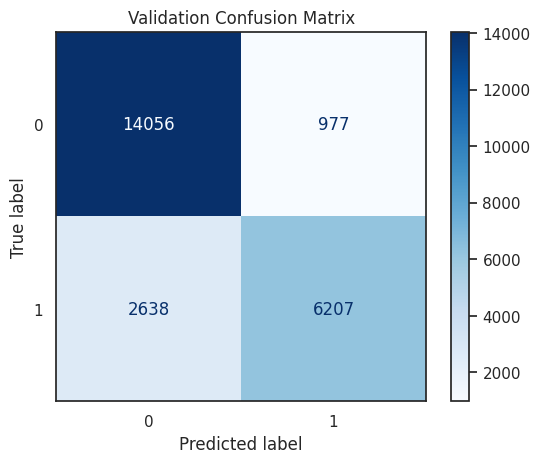

In [48]:
# Taking top 95% of RFC contributing features to remove noise
new_features = rfc_features.feature[0:25].to_list()

# Fit train and predict
rfc_model2 = rfc.fit(x_train[new_features], y_train)
rfc_train_pred2 = rfc_model2.predict(x_train[new_features])
rfc_val_pred2 = rfc_model2.predict(x_val[new_features])
rfc_test_pred2 = rfc_model2.predict(x_test[new_features])

# Evaluate accuracy
train_accuracy2 = accuracy_score(y_train, rfc_train_pred2)
val_accuracy2 = accuracy_score(y_val, rfc_val_pred2)
print(f"Random Forest Train Pred Accuracy: {train_accuracy2:.3f}\n")
print(f"Random Forest Val Pred Accuracy: {val_accuracy2:.3f}\n")

# Classification Report
print('Train Classification Report:\n', classification_report(y_train, rfc_train_pred2))
print('Val Classification Report:\n', classification_report(y_val, rfc_val_pred2))

# Create confusion matrix with labels/colors
conf_matrix = confusion_matrix(y_val, rfc_val_pred2)
c_matrix = ConfusionMatrixDisplay(conf_matrix)
c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.show()

### Using GridSearch for RFC

In [49]:
gs_rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 16],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10, 20],
    # 'max_features': ['sqrt', 'log2', 8, 16, 24]
}

grid_rf = GridSearchCV(
    estimator=gs_rfc,
    param_grid=param_grid,
    cv=5, # k-fold cross-validation
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_rf.fit(x_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
print("Best Accuracy:", grid_rf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy: 0.7411876961568292


### Random Forest Evaluations

Random Forest Train Pred Accuracy: 0.839

Random Forest Val Pred Accuracy: 0.835

Random Forest Test Pred Accuracy: 0.830

Train Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88     45099
           1       0.88      0.66      0.75     26533

    accuracy                           0.84     71632
   macro avg       0.85      0.80      0.82     71632
weighted avg       0.84      0.84      0.83     71632

Val Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88     15033
           1       0.87      0.65      0.75      8845

    accuracy                           0.84     23878
   macro avg       0.85      0.80      0.81     23878
weighted avg       0.84      0.84      0.83     23878

Test Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.88     15033
           1       0.87    

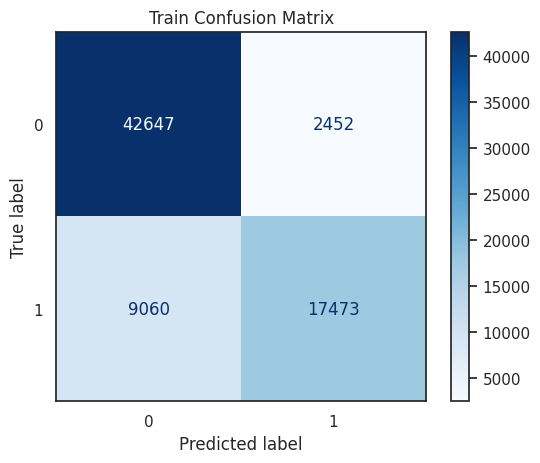

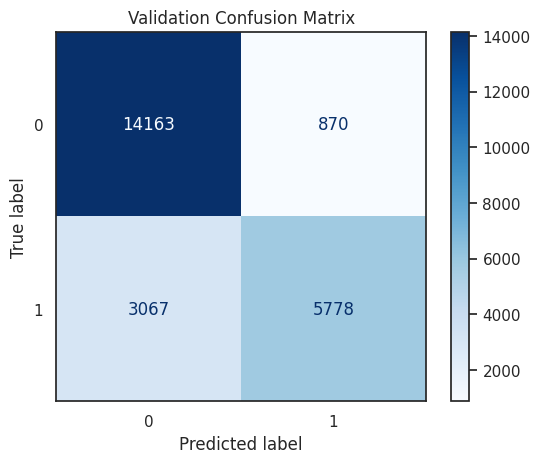

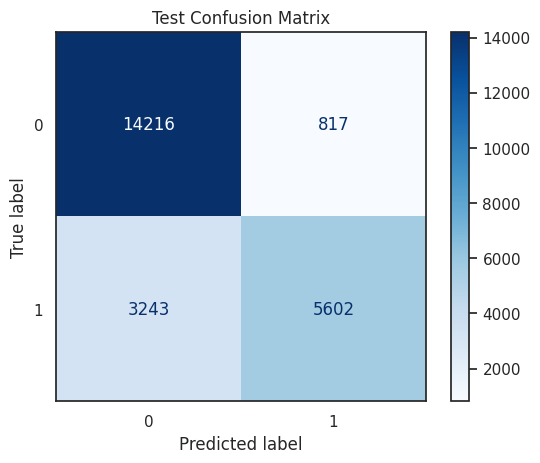

In [50]:
# Predictions
train_y_pred = grid_rf.predict(x_train)
val_y_pred = grid_rf.predict(x_val)
y_pred = grid_rf.predict(x_test)

# Evaluate accuracy
train_accuracy = accuracy_score(y_train, train_y_pred)
val_accuracy = accuracy_score(y_val, val_y_pred)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Train Pred Accuracy: {train_accuracy:.3f}\n")
print(f"Random Forest Val Pred Accuracy: {val_accuracy:.3f}\n")
print(f"Random Forest Test Pred Accuracy: {test_accuracy:.3f}\n")

# Classification Report
print('Train Classification Report:\n', classification_report(y_train, train_y_pred))
print('Val Classification Report:\n', classification_report(y_val, val_y_pred))
print('Test Classification Report:\n', classification_report(y_test, y_pred))

# Create confusion matrix with labels/colors
train_conf_matrix = confusion_matrix(y_train, train_y_pred)
train_c_matrix = ConfusionMatrixDisplay(train_conf_matrix)
train_c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Train Confusion Matrix')
plt.show()

val_conf_matrix = confusion_matrix(y_val, val_y_pred)
val_c_matrix = ConfusionMatrixDisplay(val_conf_matrix)
val_c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
c_matrix = ConfusionMatrixDisplay(conf_matrix)
c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()

# Log Loss
train_prob = grid_rf.predict_proba(x_train)[:, 1]
val_prob = grid_rf.predict_proba(x_val)[:, 1]
y_prob = grid_rf.predict_proba(x_test)[:, 1]

train_y_loss = log_loss(y_train, train_prob)
val_y_loss = log_loss(y_val, val_prob)
y_loss = log_loss(y_test, y_prob)


# Precision-Recall AUC Curves
precision_train, recall_train, thresholds = precision_recall_curve(y_train, train_prob)
pr_auc_train = auc(recall_train, precision_train)

precision_val, recall_val, thresholds = precision_recall_curve(y_val, val_prob)
pr_auc_val = auc(recall_val, precision_val)

precision_test, recall_test, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc_test = auc(recall_test, precision_test)

# ROC AUC Curves
fpr_train, tpr_train, thresholds = roc_curve(y_train, train_prob)
roc_auc_train = roc_auc_score(y_train, train_prob)

fpr_val, tpr_val, thresholds = roc_curve(y_val, val_prob)
roc_auc_val = roc_auc_score(y_val, val_prob)

fpr_test, tpr_test, thresholds = roc_curve(y_test, y_prob)
roc_auc_test = roc_auc_score(y_test, y_prob)

### Random Forest PR/ROC AUC Curve

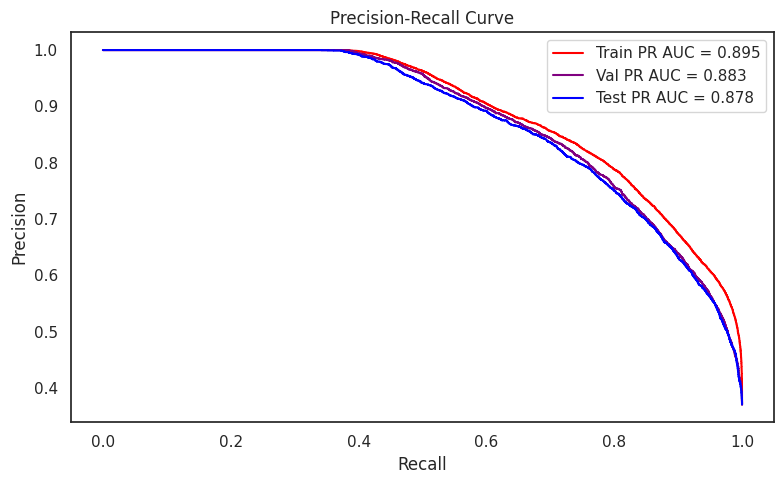

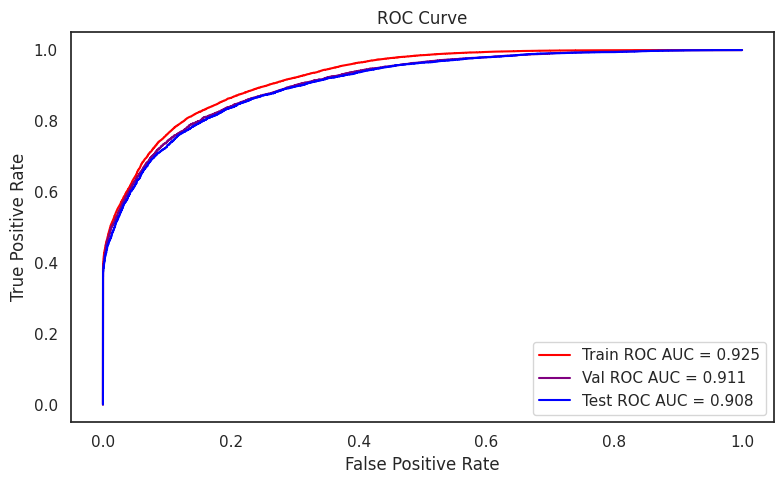

In [51]:
# PR AUC curve (precision-recall/average precision)
plt.figure(figsize=(8, 5))
plt.plot(recall_train, precision_train, color='red', label=f"Train PR AUC = {pr_auc_train:.3f}")
plt.plot(recall_val, precision_val, color='purple', label=f"Val PR AUC = {pr_auc_val:.3f}")
plt.plot(recall_test, precision_test, color='blue', label=f"Test PR AUC = {pr_auc_test:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ROC AUC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, color='red', label=f"Train ROC AUC = {roc_auc_train:.3f}")
plt.plot(fpr_val, tpr_val, color='purple', label=f"Val ROC AUC = {roc_auc_val:.3f}")
plt.plot(fpr_test, tpr_test, color='blue', label=f"Test ROC AUC = {roc_auc_test:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

## XGBoost

XGBoost Train Pred Accuracy: 0.863

XGBoost Val Pred Accuracy: 0.848

Train Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.90     45099
           1       0.87      0.74      0.80     26533

    accuracy                           0.86     71632
   macro avg       0.86      0.84      0.85     71632
weighted avg       0.86      0.86      0.86     71632

Val Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88     15033
           1       0.84      0.72      0.78      8845

    accuracy                           0.85     23878
   macro avg       0.85      0.82      0.83     23878
weighted avg       0.85      0.85      0.85     23878



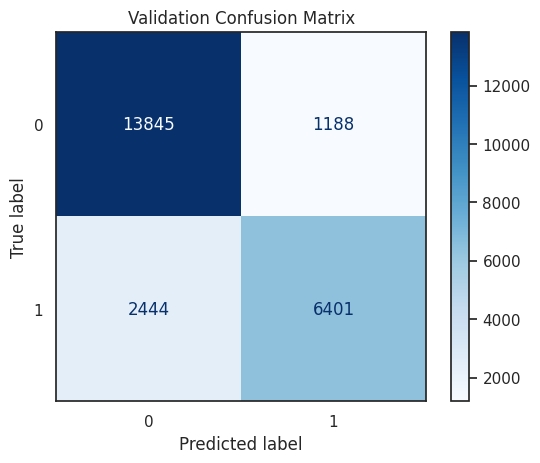

In [52]:
xgbc = xgb.XGBClassifier()
xgbc_model = xgbc.fit(x_train, y_train)

# Fit train and predict
xgbc_train_pred = xgbc_model.predict(x_train)
xgbc_val_pred = xgbc_model.predict(x_val)

# Evaluate accuracy
train_accuracy = accuracy_score(y_train, xgbc_train_pred)
val_accuracy = accuracy_score(y_val, xgbc_val_pred)
print(f"XGBoost Train Pred Accuracy: {train_accuracy:.3f}\n")
print(f"XGBoost Val Pred Accuracy: {val_accuracy:.3f}\n")

# Classification Report
print('Train Classification Report:\n', classification_report(y_train, xgbc_train_pred))
print('Val Classification Report:\n', classification_report(y_val, xgbc_val_pred))

# Create confusion matrix with labels/colors
conf_matrix = confusion_matrix(y_val, xgbc_val_pred)
c_matrix = ConfusionMatrixDisplay(conf_matrix)
c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.show()

In [53]:
xgb_features = pd.DataFrame({
    'feature': x_train.columns,
    'importance': xgbc.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

xgb_features['cum_importance'] = np.cumsum(xgb_features['importance'])

print(xgb_features)

                           feature  importance  cum_importance
0          deposit_type_non_refund    0.642747        0.642747
1            is_reserved_room_type    0.060638        0.703385
2      required_car_parking_spaces    0.052595        0.755980
3           previous_cancellations    0.044065        0.800046
4         market_segment_online_ta    0.028590        0.828636
5        total_of_special_requests    0.017409        0.846045
6          customer_type_transient    0.013391        0.859436
7    customer_type_transient_party    0.007787        0.867223
8           customer_type_contract    0.007684        0.874907
9                 continent_africa    0.006869        0.881775
10  previous_bookings_not_canceled    0.006839        0.888615
11                 booking_changes    0.006052        0.894666
12    market_segment_offline_ta_to    0.005910        0.900576
13                       lead_time    0.005806        0.906382
14                continent_europe    0.005618        0

XGBoost Train Pred Accuracy: 0.920

XGBoost Val Pred Accuracy: 0.858

XGBoost Test Pred Accuracy: 0.856

Train Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     45099
           1       0.93      0.85      0.89     26533

    accuracy                           0.92     71632
   macro avg       0.92      0.91      0.91     71632
weighted avg       0.92      0.92      0.92     71632

Val Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89     15033
           1       0.85      0.75      0.80      8845

    accuracy                           0.86     23878
   macro avg       0.85      0.84      0.84     23878
weighted avg       0.86      0.86      0.86     23878

Test Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89     15033
           1       0.85      0.74      0.79  

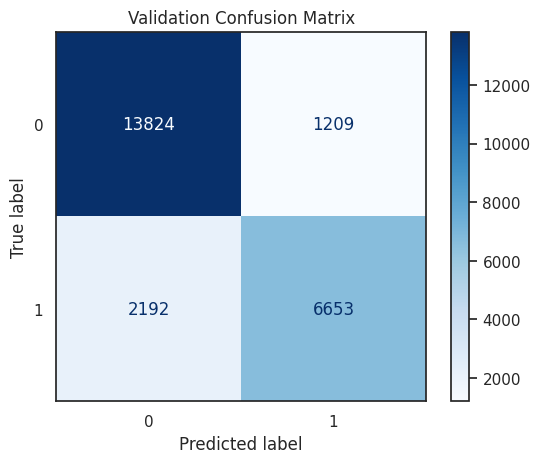

In [54]:
new_features = xgb_features.feature[:45].to_list()
xgbc2 = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, subsample=0.5)

# Fit train and predict
xgbc_model2 = xgbc2.fit(x_train[new_features], y_train)
xgbc_train_pred2 = xgbc_model2.predict(x_train[new_features])
xgbc_val_pred2 = xgbc_model2.predict(x_val[new_features])
xgbc_test_pred2 = xgbc_model2.predict(x_test[new_features])

# Evaluate accuracy
train_accuracy = accuracy_score(y_train, xgbc_train_pred2)
val_accuracy = accuracy_score(y_val, xgbc_val_pred2)
test_accuracy = accuracy_score(y_test, xgbc_test_pred2)
print(f"XGBoost Train Pred Accuracy: {train_accuracy:.3f}\n")
print(f"XGBoost Val Pred Accuracy: {val_accuracy:.3f}\n")
print(f"XGBoost Test Pred Accuracy: {test_accuracy:.3f}\n")

# Classification Report
print('Train Classification Report:\n', classification_report(y_train, xgbc_train_pred2))
print('Val Classification Report:\n', classification_report(y_val, xgbc_val_pred2))
print('Test Classification Report:\n', classification_report(y_test, xgbc_test_pred2))

# Create confusion matrix with labels/colors
conf_matrix = confusion_matrix(y_val, xgbc_val_pred2)
c_matrix = ConfusionMatrixDisplay(conf_matrix)
c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.show()


### GridSearchCV for XGBoost

#### GridSearch #1

In [55]:
param_grid = {
    'max_depth': [8, 16, 24],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

xgb_model = xgb.XGBClassifier()
grid_xgb = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1')

# Fit model
grid_xgb.fit(x_train, y_train)

print("Best set of hyperparameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 24, 'subsample': 0.7}
Best score:  0.800513902685859


#### GridSearch #2

In [56]:
# Define the hyperparameter grid
param_grid2 = {
    'max_depth': [24, 32, 48],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.5, 0.7]
}

# Create the GridSearchCV object
grid_xgb2 = GridSearchCV(xgb_model, param_grid2, cv=5, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_xgb2.fit(x_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_xgb2.best_params_)
print("Best score: ", grid_xgb2.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 24, 'subsample': 0.7}
Best score:  0.800513902685859


### XGBoost Evaluations

Random Forest Train Pred Accuracy: 0.982

Random Forest Val Pred Accuracy: 0.862

Random Forest Test Pred Accuracy: 0.861

Train Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     45099
           1       0.98      0.97      0.97     26533

    accuracy                           0.98     71632
   macro avg       0.98      0.98      0.98     71632
weighted avg       0.98      0.98      0.98     71632

Val Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     15033
           1       0.85      0.77      0.81      8845

    accuracy                           0.86     23878
   macro avg       0.86      0.84      0.85     23878
weighted avg       0.86      0.86      0.86     23878

Test Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     15033
           1       0.85    

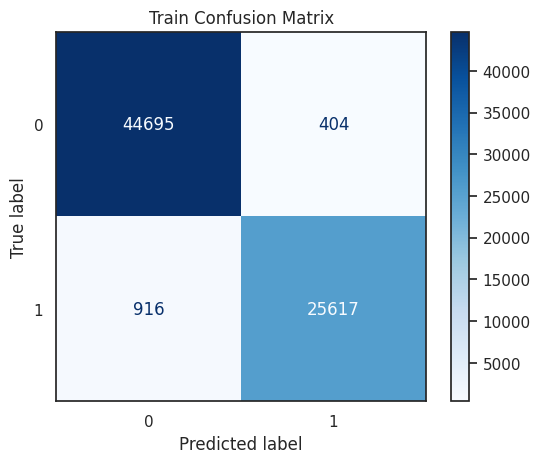

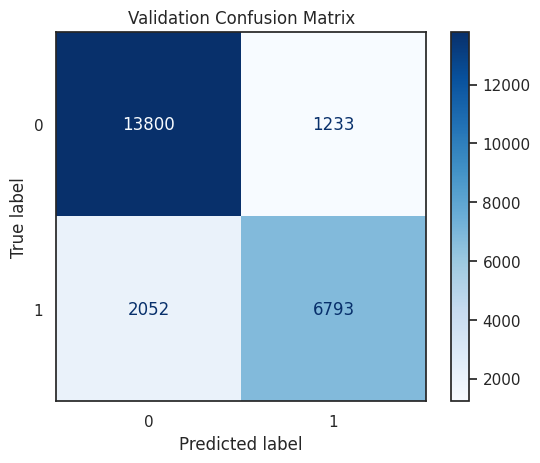

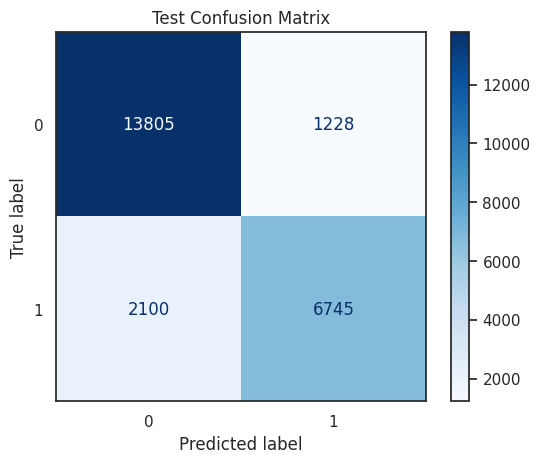

In [57]:
# Predictions
train_y_pred = grid_xgb2.predict(x_train)
val_y_pred = grid_xgb2.predict(x_val)
y_pred = grid_xgb2.predict(x_test)

# Evaluate accuracy
train_accuracy = accuracy_score(y_train, train_y_pred)
val_accuracy = accuracy_score(y_val, val_y_pred)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Train Pred Accuracy: {train_accuracy:.3f}\n")
print(f"Random Forest Val Pred Accuracy: {val_accuracy:.3f}\n")
print(f"Random Forest Test Pred Accuracy: {test_accuracy:.3f}\n")

# Classification Report
print('Train Classification Report:\n', classification_report(y_train, train_y_pred))
print('Val Classification Report:\n', classification_report(y_val, val_y_pred))
print('Test Classification Report:\n', classification_report(y_test, y_pred))

# Create confusion matrix with labels/colors
train_conf_matrix = confusion_matrix(y_train, train_y_pred)
train_c_matrix = ConfusionMatrixDisplay(train_conf_matrix)
train_c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Train Confusion Matrix')
plt.show()

val_conf_matrix = confusion_matrix(y_val, val_y_pred)
val_c_matrix = ConfusionMatrixDisplay(val_conf_matrix)
val_c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
c_matrix = ConfusionMatrixDisplay(conf_matrix)
c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()

# Log Loss
train_prob = grid_xgb2.predict_proba(x_train)[:, 1]
val_prob = grid_xgb2.predict_proba(x_val)[:, 1]
y_prob = grid_xgb2.predict_proba(x_test)[:, 1]

train_y_loss = log_loss(y_train, train_prob)
val_y_loss = log_loss(y_val, val_prob)
y_loss = log_loss(y_test, y_prob)

# Precision-Recall AUC Curves
precision_train, recall_train, thresholds = precision_recall_curve(y_train, train_prob)
pr_auc_train = auc(recall_train, precision_train)

precision_val, recall_val, thresholds = precision_recall_curve(y_val, val_prob)
pr_auc_val = auc(recall_val, precision_val)

precision_test, recall_test, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc_test = auc(recall_test, precision_test)

# ROC AUC Curves
fpr_train, tpr_train, thresholds = roc_curve(y_train, train_prob)
roc_auc_train = roc_auc_score(y_train, train_prob)

fpr_val, tpr_val, thresholds = roc_curve(y_val, val_prob)
roc_auc_val = roc_auc_score(y_val, val_prob)

fpr_test, tpr_test, thresholds = roc_curve(y_test, y_prob)
roc_auc_test = roc_auc_score(y_test, y_prob)

### XGBoost PR/ROC AUC Curve

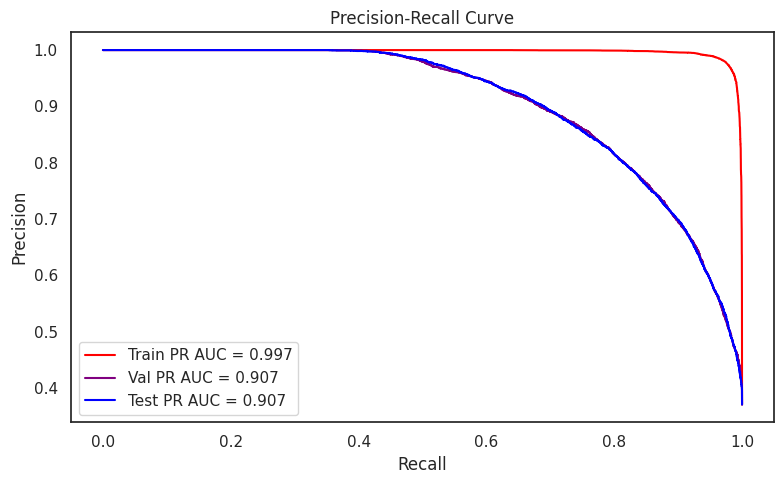

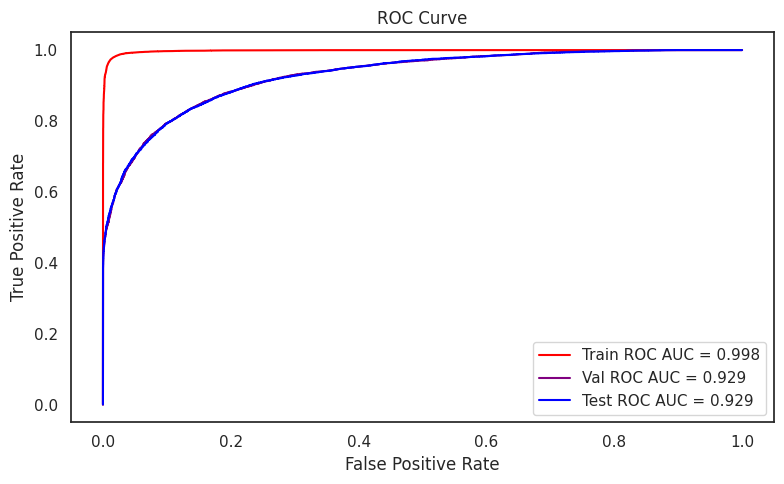

In [58]:
# PR AUC curve (precision-recall/average precision)
plt.figure(figsize=(8, 5))
plt.plot(recall_train, precision_train, color='red', label=f"Train PR AUC = {pr_auc_train:.3f}")
plt.plot(recall_val, precision_val, color='purple', label=f"Val PR AUC = {pr_auc_val:.3f}")
plt.plot(recall_test, precision_test, color='blue', label=f"Test PR AUC = {pr_auc_test:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ROC AUC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, color='red', label=f"Train ROC AUC = {roc_auc_train:.3f}")
plt.plot(fpr_val, tpr_val, color='purple', label=f"Val ROC AUC = {roc_auc_val:.3f}")
plt.plot(fpr_test, tpr_test, color='blue', label=f"Test ROC AUC = {roc_auc_test:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

## LightGBM

### GridSearchCV #1

In [59]:
lgbm = lgb.LGBMClassifier(objective="binary", metric="auc", random_state=42)
param_grid = {
    "num_leaves": [16, 32, 48],
    "max_depth": [-1, 3, 5],
    "colsample_bytree": [0.8, 1.0]
}

grid_lgbm = GridSearchCV(lgbm, param_grid, cv=5, scoring="f1", n_jobs=-1,
    verbose=1)

# Fit model
grid_lgbm.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)]
    )

print("Best Parameters:", grid_lgbm.best_params_)
print("Best Accuracy:", grid_lgbm.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 26533, number of negative: 45099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 71632, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370407 -> initscore=-0.530471
[LightGBM] [Info] Start training from score -0.530471
Best Parameters: {'colsample_bytree': 1.0, 'max_depth': -1, 'num_leaves': 48}
Best Accuracy: 0.7729105369096986


### GridSearch #2

In [60]:
param_grid2 = {
    "num_leaves": [50, 75, 100],
    "max_depth": [16, 24],
    "colsample_bytree": [1.0],
    "learning_rate": [0.5, 0.1, 0.01],
    "n_estimators": [100, 200],
}

grid_lgbm2 = GridSearchCV(lgbm, param_grid2, cv=5, scoring="f1", n_jobs=-1,
    verbose=1)

# Fit model
grid_lgbm2.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)]
    )

print("Best Parameters:", grid_lgbm2.best_params_)
print("Best Accuracy:", grid_lgbm2.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 26533, number of negative: 45099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 71632, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370407 -> initscore=-0.530471
[LightGBM] [Info] Start training from score -0.530471
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.5, 'max_depth': 16, 'n_estimators': 200, 'num_leaves': 100}
Best Accuracy: 0.7935412909247873


### GridSearch #3

In [61]:
param_grid3 = {
    "num_leaves": [100, 200],
    "max_depth": [8, 16],
    "colsample_bytree": [1.0],
    "learning_rate": [0.5, 0.1, 0.01],
    "n_estimators": [200]
}

grid_lgbm3 = GridSearchCV(lgbm, param_grid3, cv=5, scoring="f1", n_jobs=-1,
    verbose=1)

# Fit model
grid_lgbm3.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)]
    )

print("Best Parameters:", grid_lgbm3.best_params_)
print("Best Accuracy:", grid_lgbm3.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 26533, number of negative: 45099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 71632, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370407 -> initscore=-0.530471
[LightGBM] [Info] Start training from score -0.530471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 200, 'num_leaves': 200}
Best Accuracy: 0.798138904360748


### LightGBM Evaluations

Train Accuracy: 0.923

Val Accuracy: 0.860

Test Accuracy: 0.859


Train Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     45099
           1       0.92      0.86      0.89     26533

    accuracy                           0.92     71632
   macro avg       0.92      0.91      0.92     71632
weighted avg       0.92      0.92      0.92     71632


Val Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     15033
           1       0.85      0.76      0.80      8845

    accuracy                           0.86     23878
   macro avg       0.86      0.84      0.85     23878
weighted avg       0.86      0.86      0.86     23878


Test Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89     15033
           1       0.85      0.75      0.80      8845

    accuracy              

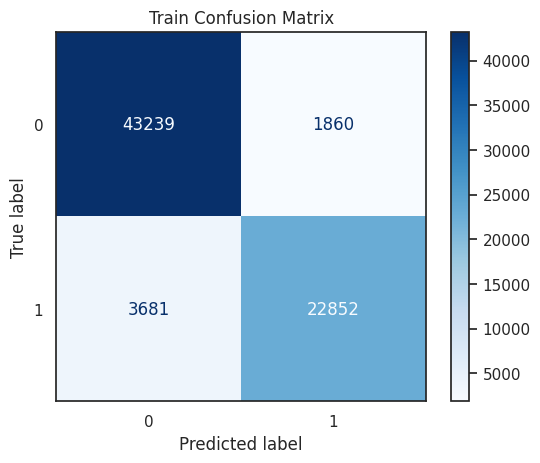

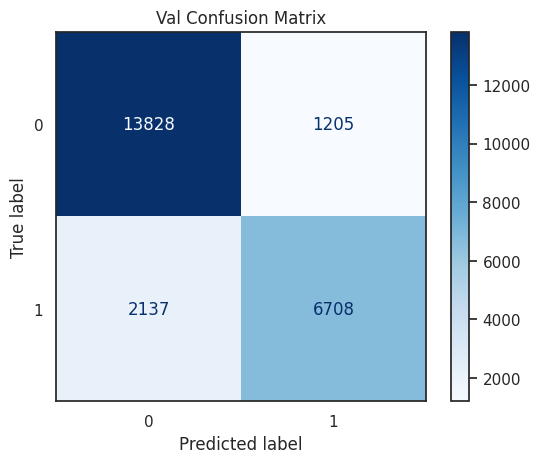

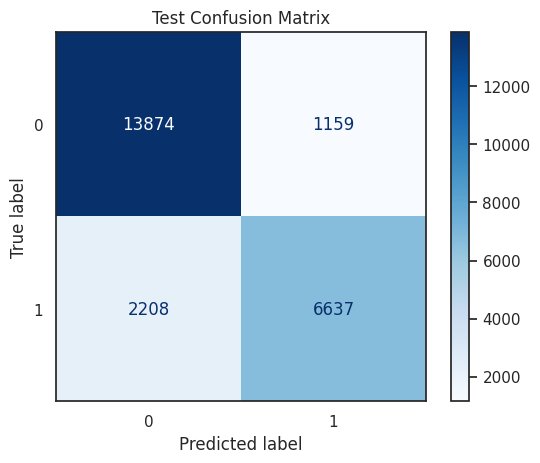

Train Log Loss: 0.199

Val Log Loss: 0.315

Test Log Loss: 0.318



In [62]:
# Predictions
train_y_pred = grid_lgbm3.predict(x_train)
val_y_pred = grid_lgbm3.predict(x_val)
y_pred = grid_lgbm3.predict(x_test)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train, train_y_pred):.3f}\n")
print(f"Val Accuracy: {accuracy_score(y_val, val_y_pred):.3f}\n")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")

# Classification Report
print('\nTrain Classification Report:\n', classification_report(y_train, train_y_pred))
print('\nVal Classification Report:\n', classification_report(y_val, val_y_pred))
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
train_conf_matrix = confusion_matrix(y_train, train_y_pred)
train_c_matrix = ConfusionMatrixDisplay(train_conf_matrix)
train_c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Train Confusion Matrix')
plt.show()

val_conf_matrix = confusion_matrix(y_val, val_y_pred)
val_c_matrix = ConfusionMatrixDisplay(val_conf_matrix)
val_c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Val Confusion Matrix')
plt.show()

test_conf_matrix = confusion_matrix(y_test, y_pred)
test_c_matrix = ConfusionMatrixDisplay(test_conf_matrix)
test_c_matrix.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()

# Log Loss
train_prob = grid_lgbm3.predict_proba(x_train)[:, 1]
val_prob = grid_lgbm3.predict_proba(x_val)[:, 1]
y_prob = grid_lgbm3.predict_proba(x_test)[:, 1]

train_y_loss = log_loss(y_train, train_prob)
val_y_loss = log_loss(y_val, val_prob)
y_loss = log_loss(y_test, y_prob)
print(f"Train Log Loss: {train_y_loss:.3f}\n")
print(f"Val Log Loss: {val_y_loss:.3f}\n")
print(f"Test Log Loss: {y_loss:.3f}\n")

# Precision-Recall AUC Curves
precision_train, recall_train, thresholds = precision_recall_curve(y_train, train_prob)
pr_auc_train = auc(recall_train, precision_train)

precision_val, recall_val, thresholds = precision_recall_curve(y_val, val_prob)
pr_auc_val = auc(recall_val, precision_val)

precision_test, recall_test, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc_test = auc(recall_test, precision_test)

# ROC AUC Curves
fpr_train, tpr_train, thresholds = roc_curve(y_train, train_prob)
roc_auc_train = roc_auc_score(y_train, train_prob)

fpr_val, tpr_val, thresholds = roc_curve(y_val, val_prob)
roc_auc_val = roc_auc_score(y_val, val_prob)

fpr_test, tpr_test, thresholds = roc_curve(y_test, y_prob)
roc_auc_test = roc_auc_score(y_test, y_prob)

### LightGBM PR/ROC AUC Curve

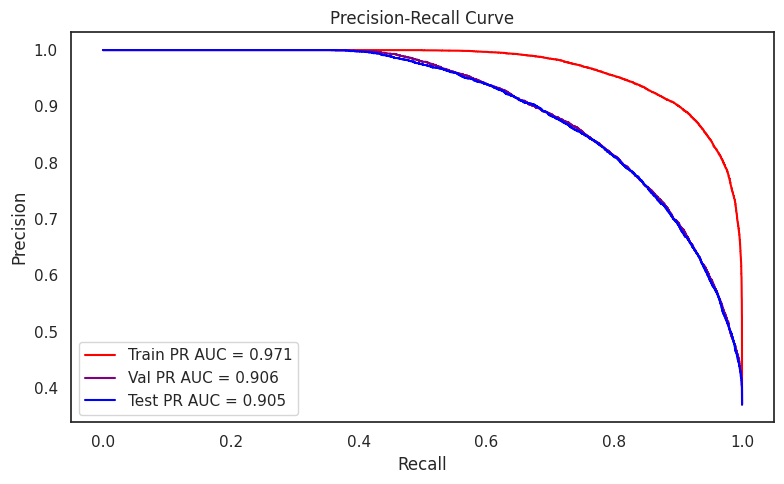

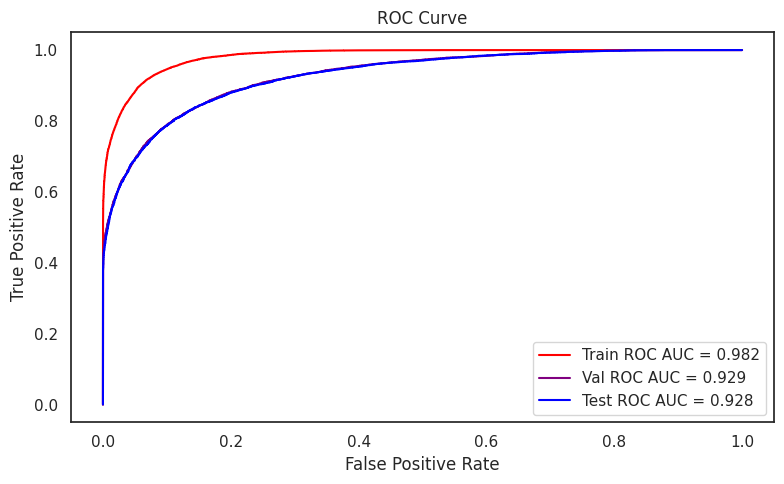

In [63]:
# PR AUC curve (precision-recall/average precision)
plt.figure(figsize=(8, 5))
plt.plot(recall_train, precision_train, color='red', label=f"Train PR AUC = {pr_auc_train:.3f}")
plt.plot(recall_val, precision_val, color='purple', label=f"Val PR AUC = {pr_auc_val:.3f}")
plt.plot(recall_test, precision_test, color='blue', label=f"Test PR AUC = {pr_auc_test:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ROC AUC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, color='red', label=f"Train ROC AUC = {roc_auc_train:.3f}")
plt.plot(fpr_val, tpr_val, color='purple', label=f"Val ROC AUC = {roc_auc_val:.3f}")
plt.plot(fpr_test, tpr_test, color='blue', label=f"Test ROC AUC = {roc_auc_test:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()